## Preparación de datos

### Modelos sin mineria de datos

##Librerias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from itertools import combinations
from xgboost import XGBClassifier
import re
from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, evaluate_model, finalize_model, predict_model, save_model, load_model
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time
df = pd.read_csv(path  + 'train.csv')
prueba = pd.read_csv(path + "test.csv")

In [ ]:
df.columns

In [ ]:
df.head(2)

In [ ]:
prueba.head(2)

In [ ]:
df.shape

## Train

In [ ]:
ft = pd.DataFrame(df.isnull().sum()).reset_index()
ft.columns = ["Variable","Faltantes"]
ft["% Faltantes"] = ft["Faltantes"] * 100 / df.shape[0]
ft.loc[ft["% Faltantes"]>0]

In [ ]:
categoricas = [
    'Marital status',
    'Nacionality',
    'Mother\'s occupation',
    'Father\'s occupation',
    'Daytime/evening attendance',
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'International','Application mode',
     'Application order'
]

# Convertir las columnas a tipo categórico en 'df'
for k in categoricas:
    if k in df.columns:
        df[k] = df[k].astype('category')

# Convertir las columnas a tipo categórico en 'prueba'
for k in categoricas:
    if k in prueba.columns:
        prueba[k] = prueba[k].astype('category')

# Verificar los cambios
print("Tipos de datos en df:")
print(df.dtypes)

print("\nTipos de datos en prueba:")
print(prueba.dtypes)



In [ ]:
formato = pd.DataFrame({'Variable': list(df.columns), 'Formato': df.dtypes })
ft = pd.merge(ft,formato,on=["Variable"],how="left")
ft.head()

## Test

In [ ]:
ft2 = pd.DataFrame(prueba.isnull().sum()).reset_index()
ft2.columns = ["Variable","Faltantes"]
ft2["% Faltantes"] = ft2["Faltantes"] * 100 / prueba.shape[0]
ft2.loc[ft2["% Faltantes"]>0]

In [ ]:
df.isnull().sum()

In [ ]:
prueba.isnull().sum()

## Análisis descriptivo

In [ ]:
cuantitativas = list(formato.loc[formato["Formato"]!="category","Variable"])
cuantitativas = [x for x in cuantitativas if x not in ["id","Target"]]
cuantitativas


In [ ]:
def asociacion(data):
    categoricas=data.columns[data.dtypes=='category']
    V1=np.array(categoricas); V2=np.array(categoricas)
    grilla=np.meshgrid(V1,V2)
    grilla=pd.DataFrame({'Var1':grilla[0].ravel(),'Var2':grilla[1].ravel()})
    p_value=[stats.chi2_contingency(pd.DataFrame(pd.crosstab(data[grilla.iloc[x]['Var1']],data[grilla.iloc[x]['Var2']])))[1] for x in range(grilla.shape[0])]

    grilla['p_value']=p_value
    grilla2=grilla.pivot(index='Var1',columns='Var2',values='p_value')
    plt.figure(figsize=(10,8))
    gr=sns.heatmap(grilla2,linewidths=0.01,annot=True,fmt='.2f',cmap='summer')
    gr.set_title('Grilla de p valores en prueba chi cuadrado para verificar asociación entre variables')
    plt.xlabel(""); plt.ylabel(""); plt.yticks(rotation=0); plt.xticks(rotation=90)
    plt.show()
    return grilla,grilla2

In [ ]:
grilla_asociacion, grilla_asociacion2 = asociacion(df.drop(["id"],axis=1))

In [ ]:
categoricas = [
    'Marital status',
    'Nacionality',
    'Mother\'s occupation',
    'Father\'s occupation',
    'Daytime/evening attendance',
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'International','Application mode',
     'Application order'
]

# Convertir las columnas a tipo categórico en 'df'
for k in categoricas:
    if k in df.columns:
        df[k] = df[k].astype('category')

# Convertir las columnas a tipo categórico en 'prueba'
for k in categoricas:
    if k in prueba.columns:
        prueba[k] = prueba[k].astype('category')

# Verificar los cambios
print("Tipos de datos en df:")
print(df.dtypes)

print("\nTipos de datos en prueba:")
print(prueba.dtypes)


In [ ]:
# Crear un diccionario para mapear los valores de la columna Target
target_mapping = {
    'Graduate': 0,
    'Dropout': 1,
    'Enrolled': 2
}

# Aplicar la conversión a la columna Target
df['Target'] = df['Target'].map(target_mapping)

# Verificar la conversión
print(df['Target'].head())


In [ ]:
df.dtypes

In [ ]:
# Modelo sin ingeniería de variables
formato = pd.DataFrame({'Variable': list(df.columns), 'Formato': df.dtypes})
categoricas = list(formato.loc[formato["Formato"] == "c", "Variable"])
categoricas = [x for x in categoricas if "Target" not in x]
numericas = list(formato.loc[formato["Formato"] != "c", "Variable"])
numericas = [x for x in numericas if "Target" not in x]
train_num = df.get(numericas)
train_cat = df.get(categoricas)

# Pycaret
exp_clf101 = setup(data = df, target='Target', session_id = 123, train_size = 0.7,
                   numeric_features = numericas,
                   categorical_features = categoricas, fix_imbalance=False)

best_model = compare_models(sort = 'Accuracy')

In [ ]:
modelo1= create_model("lightgbm")

Una media de 0.8301 indica que el modelo tiene un 83.01% de precisión en la clasificación correcta de los datos.

El modelo tiene un buen rendimiento general, con un AUC alto (0.9434), lo que significa que discrimina bien entre clases.

In [ ]:
modelo2= create_model("xgboost")

Una media de 0.8293 indica que el modelo tiene un 82.93% de precisión en la clasificación correcta de los datos.

El modelo tiene un buen rendimiento general, con un AUC alto (0.9429), lo que significa que discrimina bien entre clases

In [ ]:
modelo3= create_model("gbc")

Una media de 0.8265 indica que el modelo tiene un 82.65% de precisión en la clasificación correcta de los datos.

In [ ]:
from pycaret.classification import *
hyperparameters = modelo1.get_params()
hyperparameters

In [ ]:
from pycaret.classification import *
hyperparameters = modelo2.get_params()
hyperparameters

In [ ]:
from pycaret.classification import *
hyperparameters = modelo3.get_params()
hyperparameters

In [ ]:
import pickle
with open(path + 'best_model1.pkl', 'wb') as model_file:
    pickle.dump(modelo1, model_file)

In [ ]:
import pickle
with open(path + 'best_model2.pkl', 'wb') as model_file:
    pickle.dump(modelo2, model_file)

In [ ]:
import pickle
with open(path + 'best_model3.pkl', 'wb') as model_file:
    pickle.dump(modelo3, model_file)

In [ ]:
plot_model(modelo1, plot='confusion_matrix')

In [ ]:
plot_model(modelo2, plot='confusion_matrix')

In [ ]:
plot_model(modelo3, plot='confusion_matrix')

In [ ]:
predictions_test1 = predict_model(modelo1)
predictions_test2= predict_model(modelo2)
predictions_test3 = predict_model(modelo3)

In [ ]:
predictions_train1 = predict_model(modelo1, data=exp_clf101.get_config('X_train'))
predictions_train2= predict_model(modelo2, data=exp_clf101.get_config('X_train'))
predictions_train3 = predict_model(modelo3, data=exp_clf101.get_config('X_train'))

In [ ]:
y_train = get_config('y_train')
y_test = get_config('y_test')

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Modelo1 

# Error de entrenamiento
print(accuracy_score(y_train,predictions_train1["prediction_label"]))
# Error de test
print(accuracy_score(y_test,predictions_test1["prediction_label"]))

# Modelo2

print(accuracy_score(y_train,predictions_train2["prediction_label"]))
# Error de test
print(accuracy_score(y_test,predictions_test2["prediction_label"]))

#Modelo3

print(accuracy_score(y_train,predictions_train3["prediction_label"]))
# Error de test
print(accuracy_score(y_test,predictions_test3["prediction_label"]))

In [ ]:
%%time
# Finalizar el modelo
final_dt1 = finalize_model(modelo1)
final_dt2 = finalize_model(modelo2)
final_dt3 = finalize_model(modelo3)

In [ ]:
predictions1 = predict_model(final_dt1, data=prueba)
predictions2 = predict_model(final_dt2, data=prueba)
predictions3 = predict_model(final_dt3, data=prueba)

In [ ]:
predictions1["sc"] = predictions.apply(lambda row: 1 if row["prediction_score"]<0.9 else 0, axis = 1)
predictions1["sc"].value_counts()
predictions2["sc"] = predictions.apply(lambda row: 1 if row["prediction_score"]<0.9 else 0, axis = 1)
predictions2["sc"].value_counts()
predictions3["sc"] = predictions.apply(lambda row: 1 if row["prediction_score"]<0.9 else 0, axis = 1)
predictions3["sc"].value_counts()

In [ ]:
# Create a DataFrame with 'id' and 'Exited' probabilities
result1 = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions1['sc']
})

result1["Target"] = result1["Target"]
result1.head(5)

In [ ]:
# Create a DataFrame with 'id' and 'Exited' probabilities
result2 = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions2['sc']
})

result2["Target"] = result2["Target"]
result2.head(5)

In [ ]:
# Create a DataFrame with 'id' and 'Exited' probabilities
result3 = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions3['sc']
})

result3["Target"] = result3["Target"]
result3.head(5)

In [ ]:
inverse_category_mapping = {
    0: 'Graduate',
    1: 'Dropout',
    2: 'Enrolled'
}

# Aplicar el mapeo inverso a la columna 'Target'
result1['Target'] = result1['Target'].map(inverse_category_mapping)

# Verificar los resultados
print(result1['Target'])

In [ ]:
inverse_category_mapping = {
    0: 'Graduate',
    1: 'Dropout',
    2: 'Enrolled'
}

# Aplicar el mapeo inverso a la columna 'Target'
result2['Target'] = result2['Target'].map(inverse_category_mapping)

# Verificar los resultados
print(result2['Target'])

In [ ]:
inverse_category_mapping = {
    0: 'Graduate',
    1: 'Dropout',
    2: 'Enrolled'
}

# Aplicar el mapeo inverso a la columna 'Target'
result3['Target'] = result3['Target'].map(inverse_category_mapping)

# Verificar los resultados
print(result3['Target'])

In [ ]:
# Save the result to a CSV file
result1.to_csv(path + 'subbmision_modelo1_SIV.csv', index=False,sep=",")
# Guardar y cargar modelos
save_model(modelo1, path + 'final_dt_model_customer_churn')

# To load the model later
loaded_model = load_model(path + 'final_dt_model_customer_churn')

In [ ]:
# Save the result to a CSV file
result2.to_csv(path + 'subbmision_modelo2_SIV.csv', index=False,sep=",")
# Guardar y cargar modelos
save_model(modelo2, path + 'final_dt_model_customer_churn')

# To load the model later
loaded_model = load_model(path + 'final_dt_model_customer_churn')


In [ ]:
# Save the result to a CSV file
result3.to_csv(path + 'subbmision_modelo3_SIV.csv', index=False,sep=",")
# Guardar y cargar modelos
save_model(modelo3, path + 'final_dt_model_customer_churn')

# To load the model later
loaded_model = load_model(path + 'final_dt_model_customer_churn')

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from itertools import combinations
from xgboost import XGBClassifier
import re
from pycaret.classification import setup, compare_models, create_model, tune_model, plot_model, evaluate_model, finalize_model, predict_model, save_model, load_model
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "C:/Users/PAU/Documents/PYTHON- INTELIGENCIA ARTIFICIAL/PARCIAL_1/"

In [3]:
%%time
df = pd.read_csv(path  + 'train.csv')
prueba = pd.read_csv(path + "test.csv")

CPU times: total: 125 ms
Wall time: 372 ms


In [4]:
df.columns

Index(['id', 'Marital status', 'Application mode', 'Application order',
       'Course', 'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units

In [5]:

# Definir el mapeo de categorías a valores numéricos
category_mapping = {
    'Graduate': 0,
    'Dropout': 1,
    'Enrolled': 2
}

# Aplicar el mapeo a la columna 'Target' en el DataFrame df
df['Target'] = df['Target'].map(category_mapping)

# Si hay valores que no están en el mapeo, se convertirán en NaN.
# Opcionalmente, puedes reemplazar NaN con un valor por defecto, por ejemplo, -1:
df['Target'] = df['Target'].astype(int)


In [6]:
ct = [    'Marital status',
    'Nacionality',
    'Mother\'s occupation',
    'Father\'s occupation',
    'Daytime/evening attendance',
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'International','Application mode',
     'Application order',"Target"]

for k in ct:
  df[k] = df[k].astype("O")
  

In [7]:
ct = [    'Marital status',
    'Nacionality',
    'Mother\'s occupation',
    'Father\'s occupation',
    'Daytime/evening attendance',
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'International','Application mode',
     'Application order']

for k in ct:
    prueba[k] = prueba[k].astype("O")

In [8]:
df.head(2)

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,0
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,1


In [9]:
prueba.head(2)

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,76518,1,1,1,9500,1,1,141.0,1,3,...,0,0,8,0,0,0.0,0,13.9,-0.3,0.79
1,76519,1,1,1,9238,1,1,128.0,1,1,...,0,0,6,6,6,13.5,0,11.1,0.6,2.02


In [10]:
df.shape

(76518, 38)

## Train

In [11]:
ft = pd.DataFrame(df.isnull().sum()).reset_index()
ft.columns = ["Variable","Faltantes"]
ft["% Faltantes"] = ft["Faltantes"] * 100 / df.shape[0]
ft.loc[ft["% Faltantes"]>0]

,Variable,Faltantes,% Faltantes


In [12]:
formato = pd.DataFrame({'Variable': list(df.columns), 'Formato': df.dtypes })
ft = pd.merge(ft,formato,on=["Variable"],how="left")
ft.head()

,Variable,Faltantes,% Faltantes,Formato
0,id,0,0.0,int64
1,Marital status,0,0.0,object
2,Application mode,0,0.0,object
3,Application order,0,0.0,object
4,Course,0,0.0,int64


## Test

In [13]:
ft2 = pd.DataFrame(prueba.isnull().sum()).reset_index()
ft2.columns = ["Variable","Faltantes"]
ft2["% Faltantes"] = ft2["Faltantes"] * 100 / prueba.shape[0]
ft2.loc[ft2["% Faltantes"]>0]

,Variable,Faltantes,% Faltantes


## Análisis descriptivo

In [14]:
df.columns

Index(['id', 'Marital status', 'Application mode', 'Application order',
       'Course', 'Daytime/evening attendance', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units

In [15]:
cuantitativas = list(formato.loc[formato["Formato"]!="object","Variable"])
cuantitativas = [x for x in cuantitativas if x not in ["id","Target"]]

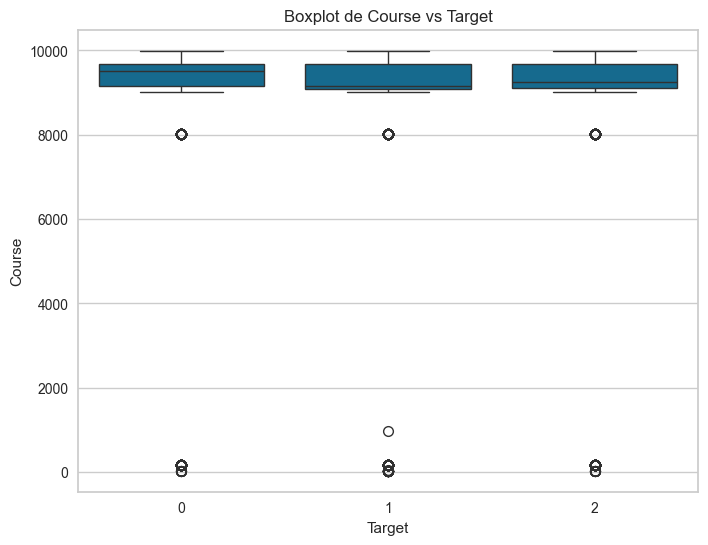

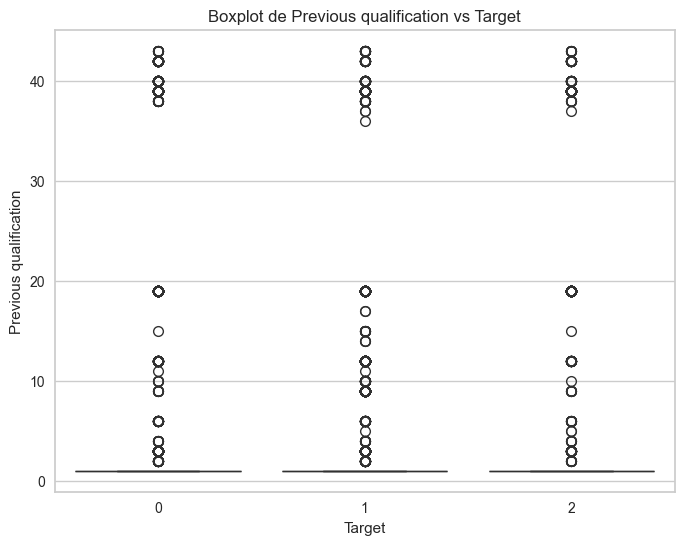

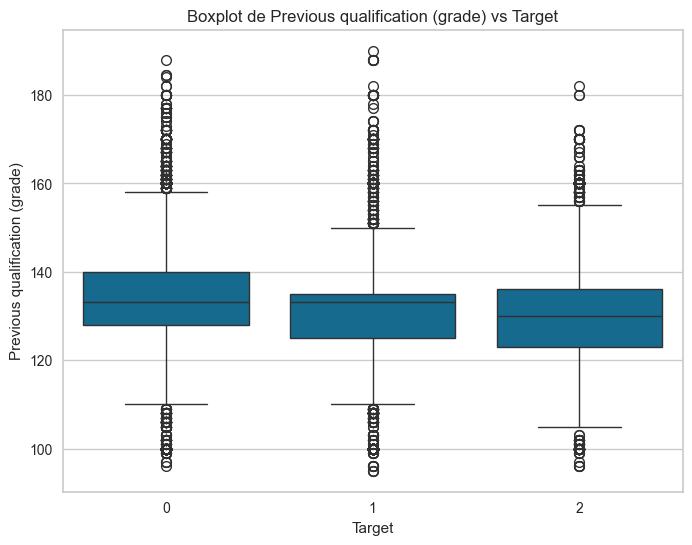

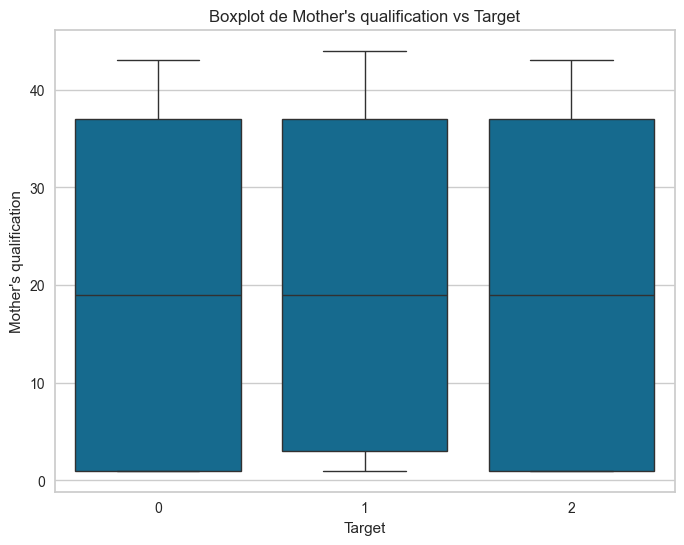

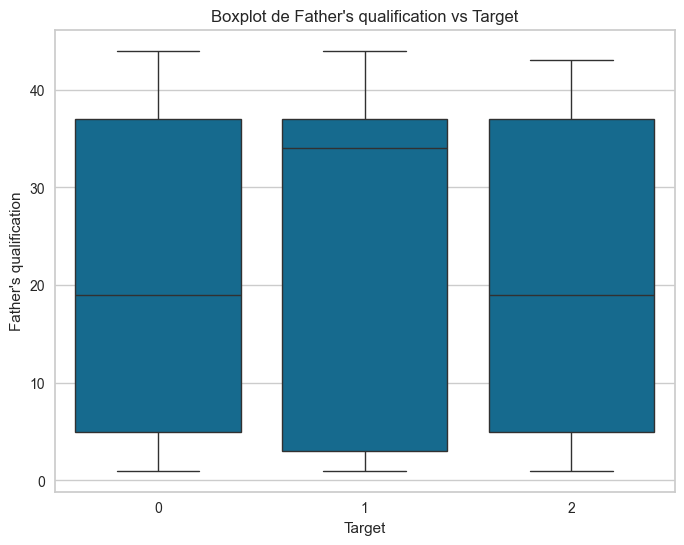

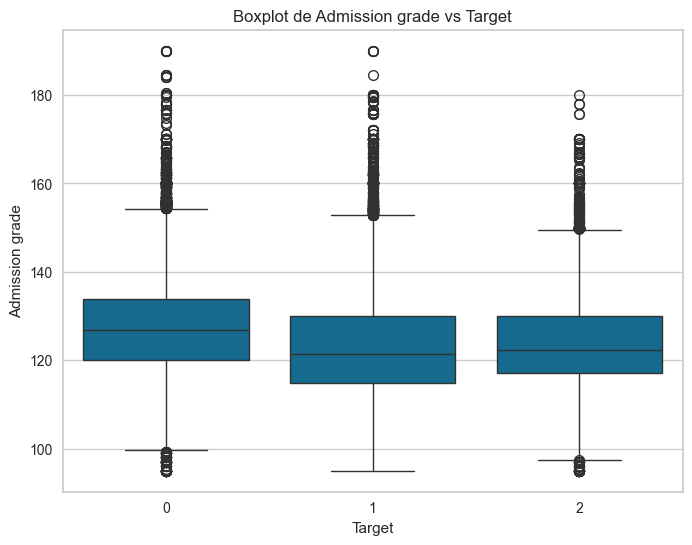

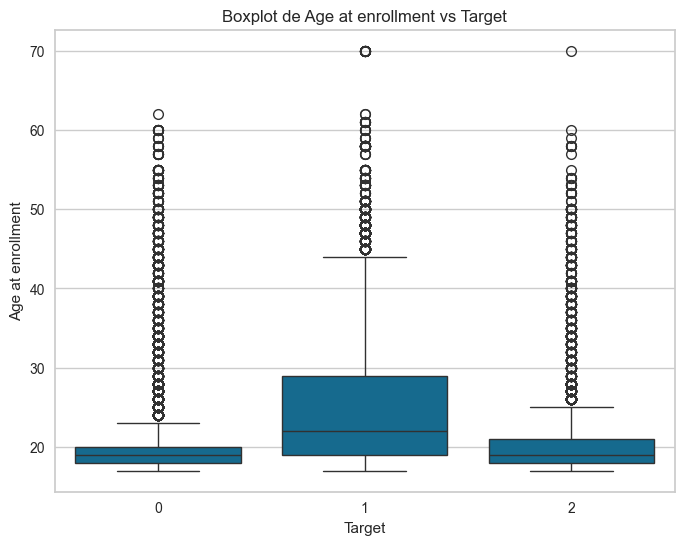

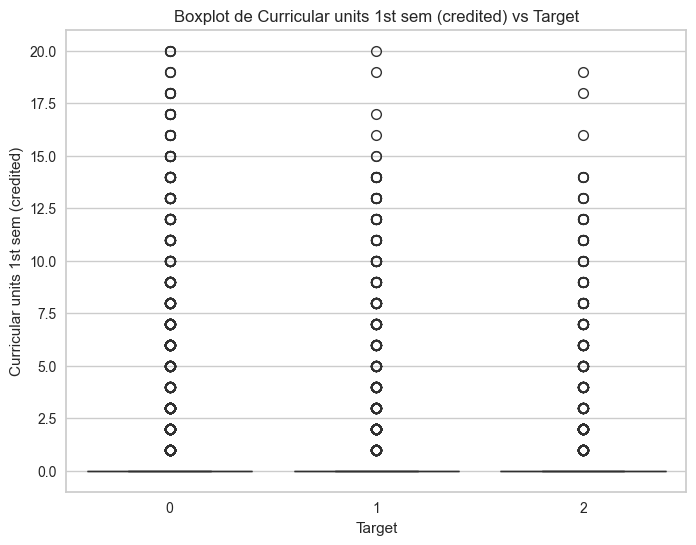

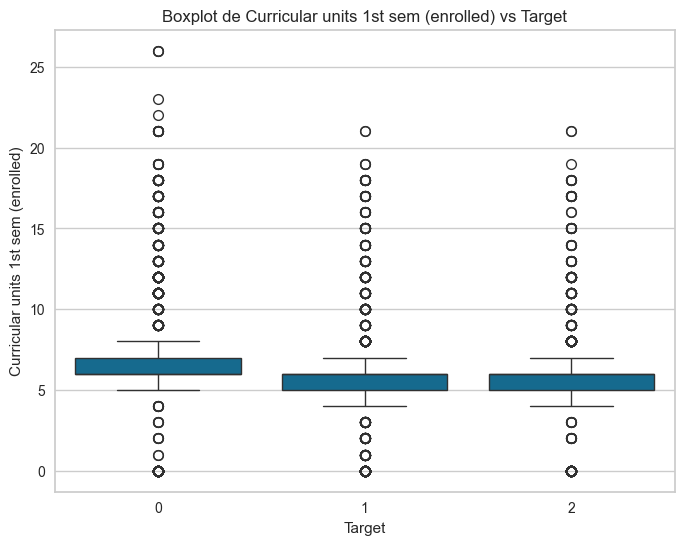

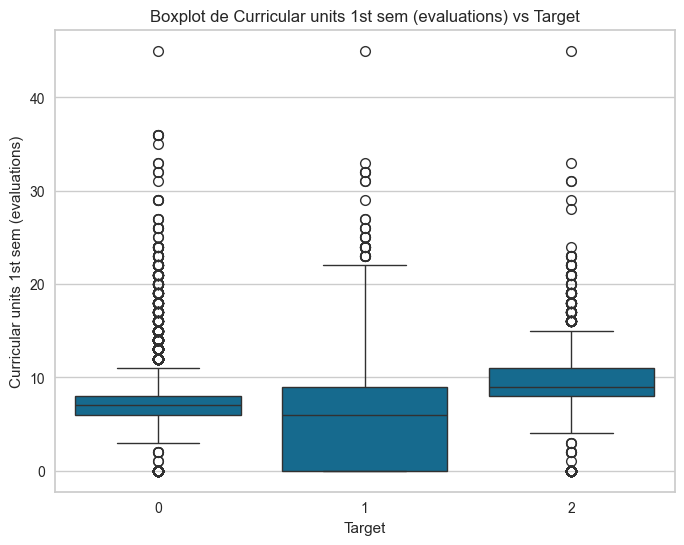

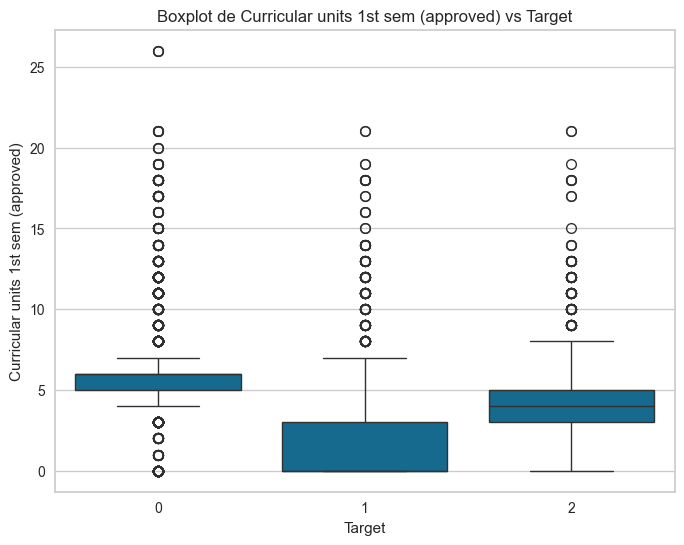

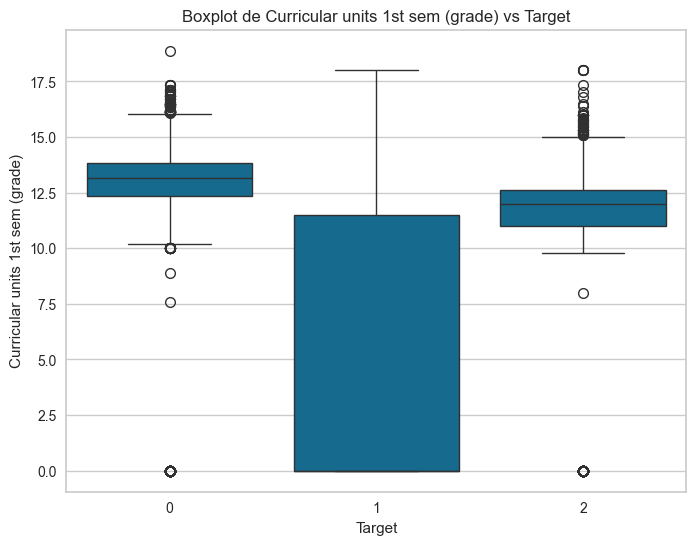

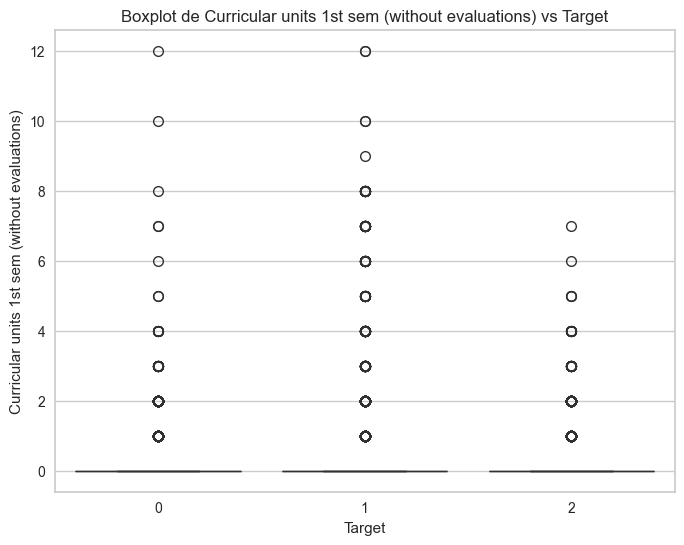

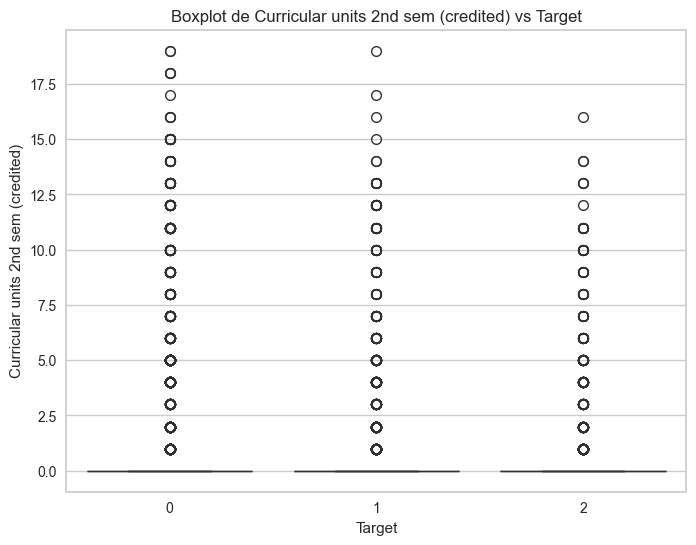

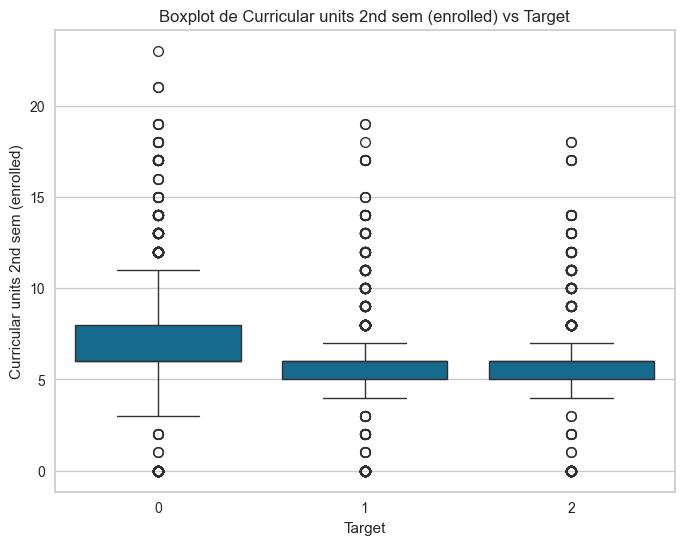

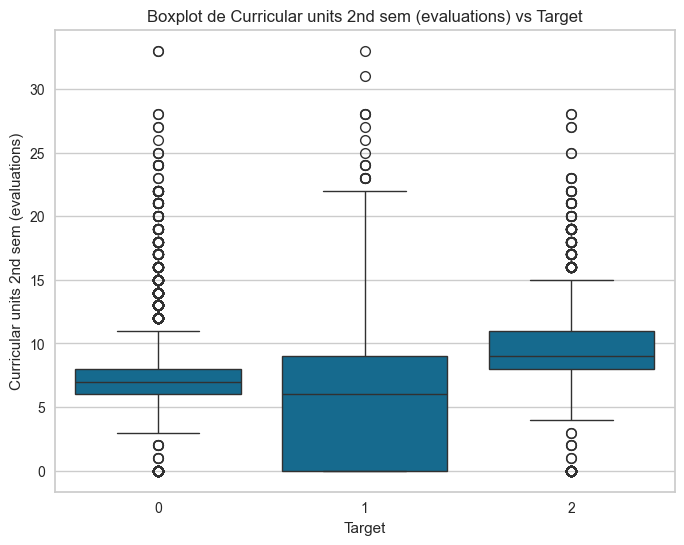

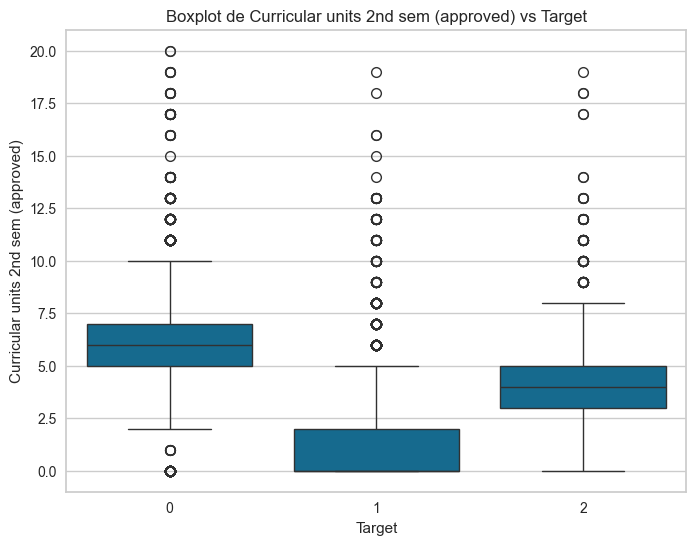

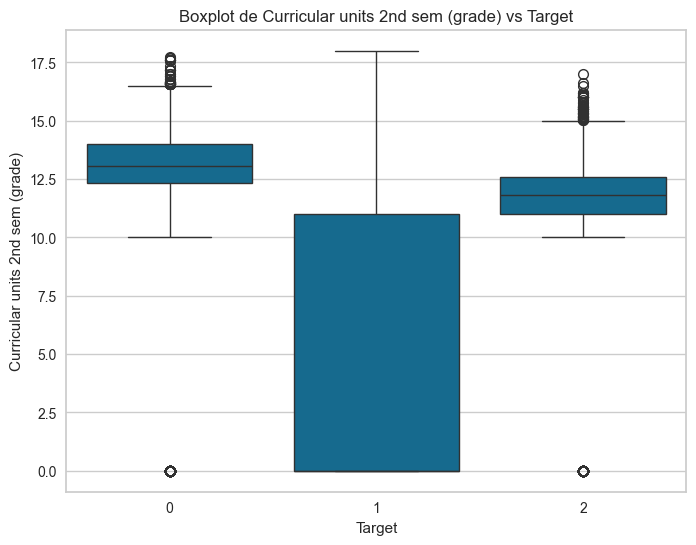

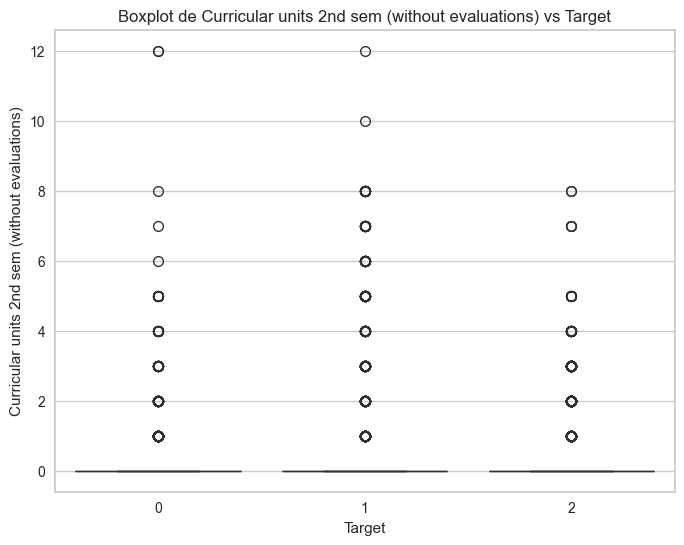

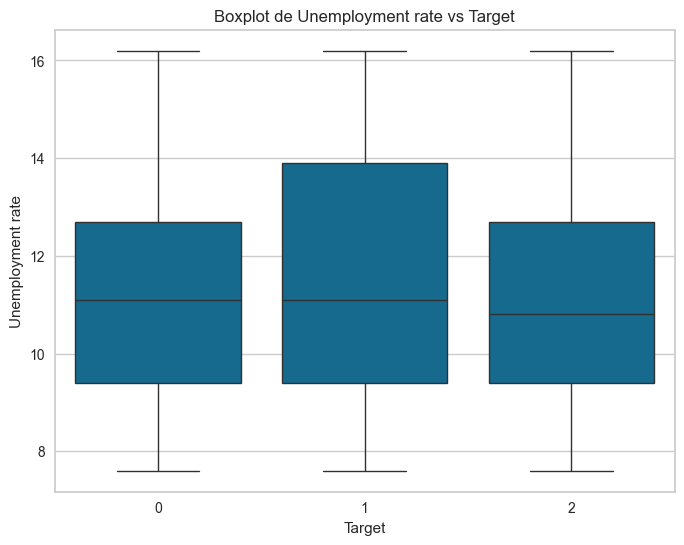

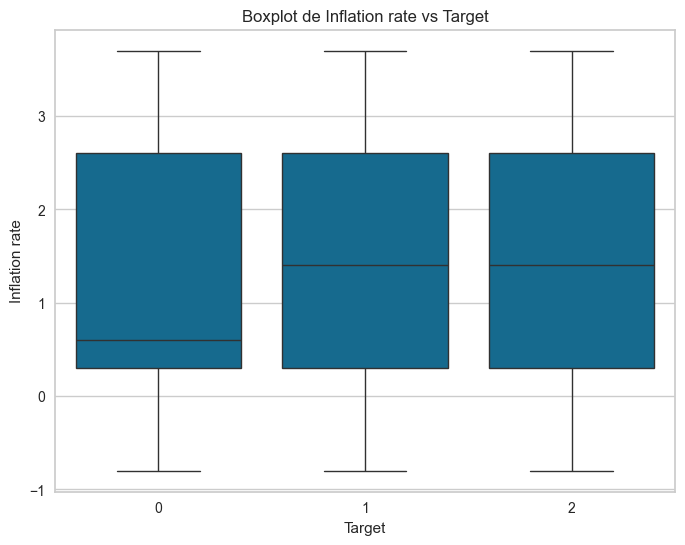

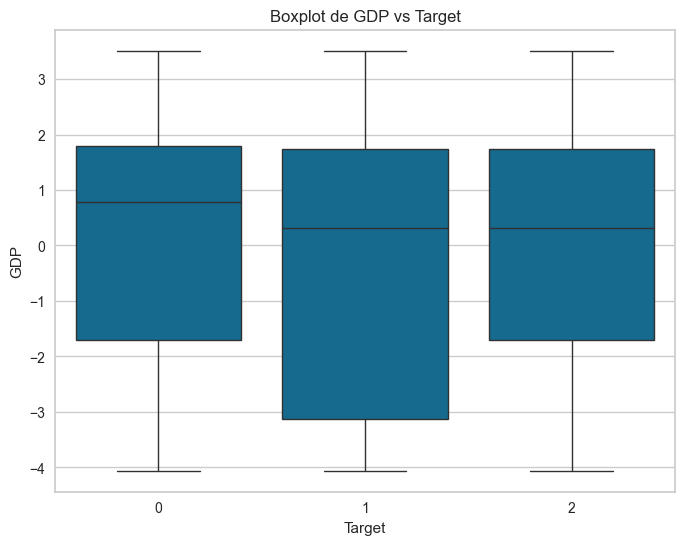

In [16]:
for k in cuantitativas:
    plt.figure(figsize=(8,6))
    sns.boxplot(x="Target",y=k,data=df)
    plt.title("Boxplot de "+k+" vs Target")

In [17]:
def asociacion(data):
    categoricas=data.columns[data.dtypes=='O']
    V1=np.array(categoricas); V2=np.array(categoricas)
    grilla=np.meshgrid(V1,V2)
    grilla=pd.DataFrame({'Var1':grilla[0].ravel(),'Var2':grilla[1].ravel()})
    p_value=[stats.chi2_contingency(pd.DataFrame(pd.crosstab(data[grilla.iloc[x]['Var1']],data[grilla.iloc[x]['Var2']])))[1] for x in range(grilla.shape[0])]

    grilla['p_value']=p_value
    grilla2=grilla.pivot(index='Var1',columns='Var2',values='p_value')
    plt.figure(figsize=(10,8))
    gr=sns.heatmap(grilla2,linewidths=0.01,annot=True,fmt='.2f',cmap='summer')
    gr.set_title('Grilla de p valores en prueba chi cuadrado para verificar asociación entre variables')
    plt.xlabel(""); plt.ylabel(""); plt.yticks(rotation=0); plt.xticks(rotation=90)
    plt.show()
    return grilla,grilla2

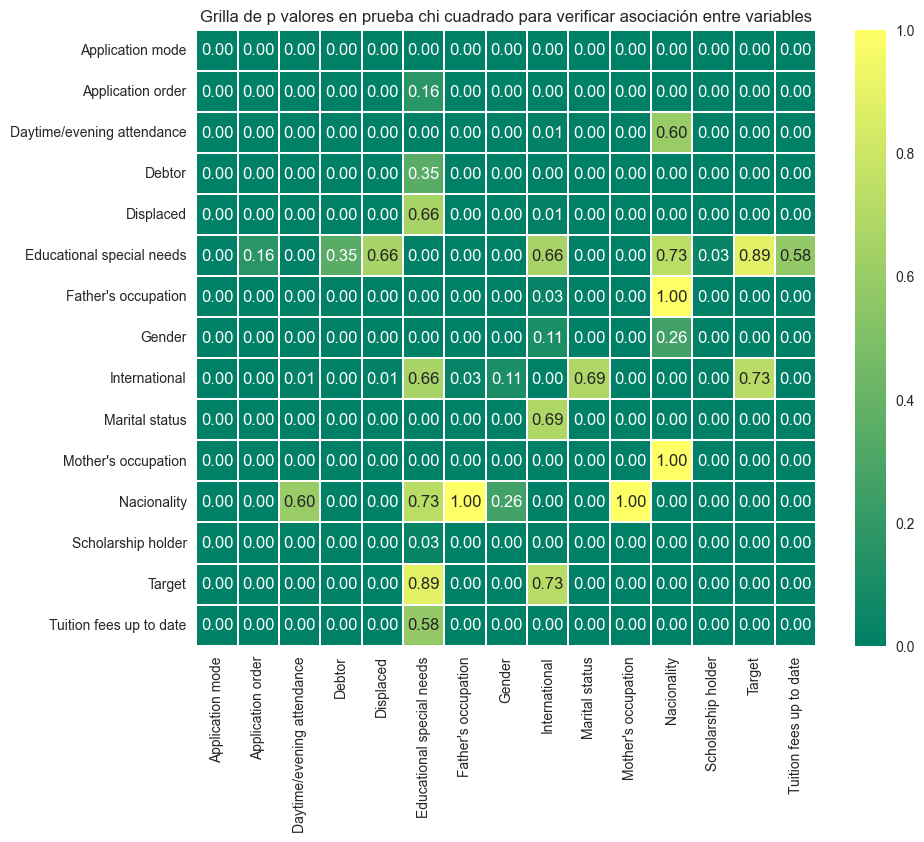

In [18]:
grilla_asociacion, grilla_asociacion2 = asociacion(df.drop(["id"],axis=1))

## Ingeniería de variables

### variables al cuadrado

In [19]:
def prueba_kr(x):
  if x<=0.10:
    return 1
  else:
    return 0

def criterion_(df,columns):
  for k in columns:
    df[k] = df[k].map(prueba_kr)
  df["criterio"] = np.sum(df.get(columns),axis=1)
  df["criterio"] = df.apply(lambda row: 1 if row["criterio"]==3 else 0,axis = 1)
  return df

In [20]:
df["Target"].unique()

array([0, 1, 2], dtype=object)

In [21]:
base_cuadrado = df.get(cuantitativas).copy()
base_cuadrado["Target"] = df["Target"].copy()

var_names2, pvalue1, pvalue2, pvalue3 = [], [],[], []

for k in cuantitativas:
    base_cuadrado[k+"_2"] = base_cuadrado[k] ** 2

    # Prueba de Kruskal sin logaritmo
    mue1 = base_cuadrado.loc[base_cuadrado["Target"]==0,k+"_2"].to_numpy()
    mue2 = base_cuadrado.loc[base_cuadrado["Target"]==1,k+"_2"].to_numpy()
    mue3 = base_cuadrado.loc[base_cuadrado["Target"]==2,k+"_2"].to_numpy()
    
    p1 = stats.kruskal(mue1, mue2)[1]
    p2 = stats.kruskal(mue2, mue3)[1]
    p3 = stats.kruskal(mue1, mue3)[1]
    # Guardar p-values y variables
    var_names2.append(k+"_2")
    pvalue1.append(np.round(p1, 2))
    pvalue2.append(np.round(p2, 2))
    pvalue3.append(np.round(p3, 2))   

In [23]:
import pandas as pd

# Crear el DataFrame con los p-values
pcuadrado1 = pd.DataFrame({
    'Variable2': var_names2,
    'p value1': pvalue1,
    'p value2': pvalue2,
    'p value3': pvalue3
})

# Aplicar el criterio a cada columna de p-values
for col in ['p value1', 'p value2', 'p value3']:
    pcuadrado1[f'criterio_{col}'] = pcuadrado1.apply(lambda row: 1 if row[col] <= 0.10 else 0, axis=1)

# Mostrar las primeras filas del DataFrame
print(pcuadrado1.head(5))


                          Variable2  p value1  p value2  p value3  \
0                          Course_2       0.0       0.0      0.00   
1          Previous qualification_2       0.0       0.0      0.00   
2  Previous qualification (grade)_2       0.0       0.0      0.00   
3          Mother's qualification_2       0.0       0.0      0.09   
4          Father's qualification_2       0.0       0.0      0.01   

   criterio_p value1  criterio_p value2  criterio_p value3  
0                  1                  1                  1  
1                  1                  1                  1  
2                  1                  1                  1  
3                  1                  1                  1  
4                  1                  1                  1  


## Interacciones cuantitativas

In [24]:
lista_inter = list(combinations(cuantitativas,2))
base_interacciones = df.get(cuantitativas).copy()
var_interaccion, pv1, pv2, pv3 = [], [],[], []
base_interacciones["Target"] = df["Target"].copy()

for k in lista_inter:
    base_interacciones[k[0]+"__"+k[1]] = base_interacciones[k[0]] * base_interacciones[k[1]]

    # Prueba de Kruskal
    mue1 = base_interacciones.loc[base_interacciones["Target"]==0,k[0]+"__"+k[1]].to_numpy()
    mue2 = base_interacciones.loc[base_interacciones["Target"]==1,k[0]+"__"+k[1]].to_numpy()
    mue3 = base_interacciones.loc[base_interacciones["Target"]==2,k[0]+"__"+k[1]].to_numpy()

    p1 = stats.kruskal(mue1, mue2)[1]
    p2 = stats.kruskal(mue2, mue3)[1]
    p3 = stats.kruskal(mue1, mue3)[1]
    # Guardar p-values y variables

    var_interaccion.append(k[0] + "__" + k[1])
    pv1.append(np.round(p1, 2))
    pv2.append(np.round(p2, 2))
    pv3.append(np.round(p3, 2))

In [25]:
pxy = pd.DataFrame({'Variable': var_interaccion, 'p value': pv1 , 'p value 2': pv2,'p value 3': pv3})
pxy["criterio"] = pxy.apply(lambda row: 1 if row["p value"]<=0.10 else 0, axis = 1)
pxy.head()

,Variable,p value,p value 2,p value 3,criterio
0,Course__Previous qualification,0.00,0.0,0.0,1
1,Course__Previous qualification (grade),0.00,0.0,0.0,1
2,Course__Mother's qualification,0.35,0.0,0.0,0
3,Course__Father's qualification,0.00,0.0,0.0,1
4,Course__Admission grade,0.00,0.0,0.0,1


## Razones

In [26]:
raz1 = [(x,y) for x in cuantitativas for y in cuantitativas]
base_razones1 = df.get(cuantitativas).copy()
base_razones1["Target"] = df["Target"].copy()

var_nm, pval1,pval2, pval3 = [], [],[], []
for j in raz1:
    if j[0]!=j[1]:
        base_razones1[j[0]+"__coc__"+j[1]] = base_razones1[j[0]] / (base_razones1[j[1]]+0.01)

        # Prueba de Kruskal
        mue1 = base_razones1.loc[base_razones1["Target"]==0,j[0]+"__coc__"+j[1]].to_numpy()
        mue2 = base_razones1.loc[base_razones1["Target"]==1,j[0]+"__coc__"+j[1]].to_numpy()
        mue3 = base_razones1.loc[base_razones1["Target"]==2,j[0]+"__coc__"+j[1]].to_numpy()

        p1 = stats.kruskal(mue1, mue2)[1]
        p2 = stats.kruskal(mue2, mue3)[1]
        p3 = stats.kruskal(mue1, mue3)[1]
        # Guardar p-values y variables
        pval1.append(np.round(p1, 2))
        pval2.append(np.round(p2, 2))
        pval3.append(np.round(p3, 2))
        # Guardar valores
        var_nm.append(j[0] + "__coc__" + j[1])

In [27]:
prazones = pd.DataFrame({'Variable': var_nm, 'p value': pval1 , 'p value 2': pval2,'p value 3': pval3 })
prazones["criterio"] = prazones.apply(lambda row: 1 if row["p value"]<=0.10 else 0, axis = 1)
prazones.head()

,Variable,p value,p value 2,p value 3,criterio
0,Course__coc__Previous qualification,0.0,0.00,0.0,1
1,Course__coc__Previous qualification (grade),0.0,0.00,0.0,1
2,Course__coc__Mother's qualification,0.0,0.00,0.0,1
3,Course__coc__Father's qualification,0.0,0.00,0.0,1
4,Course__coc__Admission grade,0.0,0.28,0.0,1


## Interacciones categóricas

In [28]:
categoricas = list(formato.loc[formato["Formato"]=="O","Variable"])
categoricas = [x for x in categoricas if x not in ["id","Target"]]

def nombre_(x):
  return "C"+str(x)

In [29]:
cb = list(combinations(categoricas,2))
p_value, modalidades, nombre_var = [], [], []

base2 = df.get(categoricas).copy()
for k in base2.columns:
  base2[k] = base2[k].map(nombre_)

base2["Target"] = df["Target"].copy()

for k in range(len(cb)):
    # Variable con interacción
    base2[cb[k][0]] = base2[cb[k][0]]
    base2[cb[k][1]] = base2[cb[k][1]]

    base2[cb[k][0]+"__"+cb[k][1]] = base2[cb[k][0]] + "__" + base2[cb[k][1]]

    # Prueba chi cuadrado
    c1 = pd.DataFrame(pd.crosstab(base2["Target"],base2[cb[k][0]+"__"+cb[k][1]]))
    pv = stats.chi2_contingency(c1)[1]

    # Número de modalidades por categoría
    mod_ = len(base2[cb[k][0]+"__"+cb[k][1]].unique())

    # Guardar p value y modalidades
    nombre_var.append(cb[k][0]+"__"+cb[k][1])
    modalidades.append(mod_)
    p_value.append(pv)

In [30]:
pc = pd.DataFrame({'Variable':nombre_var,'Num Modalidades':modalidades,'p value':p_value})
pc.loc[(pc["p value"]<=0.20) & (pc["Num Modalidades"]<=8),].sort_values(["p value"],ascending=True).head()

,Variable,Num Modalidades,p value
39,Daytime/evening attendance__Displaced,4,0.0
88,Gender__Scholarship holder,4,0.0
87,Tuition fees up to date__International,4,0.0
86,Tuition fees up to date__Scholarship holder,4,0.0
85,Tuition fees up to date__Gender,4,0.0


## Dummies categóricas más significativas (p value <= 0.20 y bajo número de modalidades)

In [31]:
def indicadora(x):
  if x==True:
    return 1
  else:
    return 0

seleccion1 = list(pc.loc[(pc["p value"]<=0.20) & (pc["Num Modalidades"]<=8),"Variable"])
sel1 = base2.get(seleccion1)

contador = 0
for k in sel1:
    if contador==0:
        lb1 = pd.get_dummies(sel1[k],drop_first=True)
        lb1.columns = [k + "_" + x for x in lb1.columns]
    else:
        lb2 = pd.get_dummies(sel1[k],drop_first=True)
        lb2.columns = [k + "_" + x for x in lb2.columns]
        lb1 = pd.concat([lb1,lb2],axis=1)
    contador = contador + 1

for k in lb1.columns:
  lb1[k] = lb1[k].map(indicadora)

lb1["Target"] = df["Target"].copy()
lb1.head(3)

,Daytime/evening attendance__Displaced_C0__C1,Daytime/evening attendance__Displaced_C1__C0,Daytime/evening attendance__Displaced_C1__C1,Daytime/evening attendance__Educational special needs_C0__C1,Daytime/evening attendance__Educational special needs_C1__C0,Daytime/evening attendance__Educational special needs_C1__C1,Daytime/evening attendance__Debtor_C0__C1,Daytime/evening attendance__Debtor_C1__C0,Daytime/evening attendance__Debtor_C1__C1,Daytime/evening attendance__Tuition fees up to date_C0__C1,...,Gender__Scholarship holder_C0__C1,Gender__Scholarship holder_C1__C0,Gender__Scholarship holder_C1__C1,Gender__International_C0__C1,Gender__International_C1__C0,Gender__International_C1__C1,Scholarship holder__International_C0__C1,Scholarship holder__International_C1__C0,Scholarship holder__International_C1__C1,Target
0,0,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1


## Interacción cuantitativa vs categórica

In [32]:
cat_cuanti = [(x,y) for x in cuantitativas for y in categoricas]
cat_cuanti[0]

('Course', 'Marital status')

In [34]:
v1, v2, pvalores_min, pvalores_max  = [], [], [], []

for j in cat_cuanti:
    k1 = j[0]
    k2 = j[1]

    g1 = pd.get_dummies(df[k2])
    lt1 = list(g1.columns)

    for k in lt1:
        g1[k] = g1[k] * df[k1]

    g1["Target"] = df["Target"].copy()

    pvalues_c = []
    for y in lt1:
        mue1 = g1.loc[g1["Target"]==0,y].to_numpy()
        mue2 = g1.loc[g1["Target"]==1,y].to_numpy()
        mue3 = g1.loc[g1["Target"]==2,y].to_numpy()

        try:
          pval = (stats.kruskal(mue1,mue2)[1]<=0.20)
          if pval==True:
              pval = 1
          else:
              pval = 0
        except ValueError:
          pval = 0

        try:
          pval2 = (stats.kruskal(mue1,mue3)[1]<=0.20)
          if pval==True:
              pval = 1
          else:
              pval = 0
        except ValueError:
          pval = 0

        try:
          pval3 = (stats.kruskal(mue3,mue2)[1]<=0.20)
          if pval==True:
              pval = 1
          else:
              pval = 0
        except ValueError:
          pval = 0
        pvalues_c.append(pval)

    min_ = np.min(pvalues_c) # Se revisa si alguna de las categorías no es significativa
    max_ = np.max(pvalues_c) # Se revisa si alguna de las categorías es significativa
    v1.append(k1) # nombre de la variable 1
    v2.append(k2) # nombre de la variable 2
    pvalores_min.append(np.round(min_,2))
    pvalores_max.append(np.round(max_,2))

In [35]:
pc2 = pd.DataFrame({'Cuantitativa':v1,'Categórica':v2,'p value':pvalores_min, 'p value max':pvalores_max})
pc2.loc[(pc2["p value"]==1) & (pc2["p value max"]==1),]

,Cuantitativa,Categórica,p value,p value max
3,Course,Daytime/evening attendance,1,1
7,Course,Displaced,1,1
9,Course,Debtor,1,1
10,Course,Tuition fees up to date,1,1
11,Course,Gender,1,1
...,...,...,...,...
303,GDP,Debtor,1,1
304,GDP,Tuition fees up to date,1,1
305,GDP,Gender,1,1
306,GDP,Scholarship holder,1,1


## Base de Feature Enginnering

In [36]:
v1 = list(pc2.loc[(pc2["p value"]==1) & (pc2["p value max"]==1),"Cuantitativa"])
v2 = list(pc2.loc[(pc2["p value"]==1) & (pc2["p value max"]==1),"Categórica"])

In [37]:
for j in range(len(v1)):

    if j==0:
        g1 = pd.get_dummies(df[v2[j]],drop_first=True)
        lt1 = list(g1.columns)
        for k in lt1:
            g1[k] = g1[k] * df[v1[j]]
        g1.columns = [v1[j] + "_" + v2[j] + "_" + str(x) for x in lt1]
    else:
        g2 = pd.get_dummies(df[v2[j]],drop_first=True)
        lt1 = list(g2.columns)
        for k in lt1:
            g2[k] = g2[k] * df[v1[j]]
        g2.columns = [v1[j] + "_" + v2[j] + "_" + str(x) for x in lt1]
        g1 = pd.concat([g1,g2],axis=1)

g1["Target"] = df["Target"].copy()
g1.head(5)

,Course_Daytime/evening attendance_1,Course_Displaced_1,Course_Debtor_1,Course_Tuition fees up to date_1,Course_Gender_1,Course_Scholarship holder_1,Previous qualification_Daytime/evening attendance_1,Previous qualification_Displaced_1,Previous qualification_Debtor_1,Previous qualification_Tuition fees up to date_1,...,Inflation rate_Gender_1,Inflation rate_Scholarship holder_1,GDP_Displaced_1,GDP_Educational special needs_1,GDP_Debtor_1,GDP_Tuition fees up to date_1,GDP_Gender_1,GDP_Scholarship holder_1,GDP_International_1,Target
0,9238,0,0,9238,0,9238,1,0,0,1,...,0.0,0.6,0.00,0.0,0.0,2.02,0.00,2.02,0.0,0
1,9238,9238,0,9238,0,0,1,1,0,1,...,0.0,0.0,2.02,0.0,0.0,2.02,0.00,0.00,0.0,1
2,9254,0,0,9254,9254,0,1,0,0,1,...,0.3,0.0,-0.00,-0.0,-0.0,-0.92,-0.92,-0.00,-0.0,1
3,9500,9500,0,9500,0,9500,1,1,0,1,...,0.0,0.6,2.02,0.0,0.0,2.02,0.00,2.02,0.0,2
4,9500,9500,0,9500,0,0,1,1,0,1,...,0.0,0.0,0.32,0.0,0.0,0.32,0.00,0.00,0.0,0


## Selección de variables con XGBOOST

### variables al cuadrado

In [38]:
pcuadrado1.head()

,Variable2,p value1,p value2,p value3,criterio_p value1,criterio_p value2,criterio_p value3
0,Course_2,0.0,0.0,0.00,1,1,1
1,Previous qualification_2,0.0,0.0,0.00,1,1,1
2,Previous qualification (grade)_2,0.0,0.0,0.00,1,1,1
3,Mother's qualification_2,0.0,0.0,0.09,1,1,1
4,Father's qualification_2,0.0,0.0,0.01,1,1,1


In [39]:
var_cuad = list(pcuadrado1["Variable2"])
base_modelo1 = base_cuadrado.get(var_cuad+["Target"])
base_modelo1["Target"] = base_modelo1["Target"].map(int)
base_modelo1.head()

,Course_2,Previous qualification_2,Previous qualification (grade)_2,Mother's qualification_2,Father's qualification_2,Admission grade_2,Age at enrollment_2,Curricular units 1st sem (credited)_2,Curricular units 1st sem (enrolled)_2,Curricular units 1st sem (evaluations)_2,...,Curricular units 2nd sem (credited)_2,Curricular units 2nd sem (enrolled)_2,Curricular units 2nd sem (evaluations)_2,Curricular units 2nd sem (approved)_2,Curricular units 2nd sem (grade)_2,Curricular units 2nd sem (without evaluations)_2,Unemployment rate_2,Inflation rate_2,GDP_2,Target
0,85340644,1,15876.0,1,361,15030.76,324,0,36,36,...,0,36,49,36,154.469388,0,123.21,0.36,4.0804,0
1,85340644,1,15625.0,361,361,14352.04,324,0,36,64,...,0,36,81,0,0.000000,0,123.21,0.36,4.0804,1
2,85636516,1,18769.0,9,361,20938.09,324,0,36,0,...,0,36,0,0,0.000000,0,262.44,0.09,0.8464,1
3,90250000,1,17161.0,361,9,15901.21,324,0,49,81,...,0,64,121,49,164.352400,0,123.21,0.36,4.0804,2
4,90250000,1,17424.0,361,1369,14424.01,324,0,49,144,...,0,49,144,36,167.271111,0,57.76,6.76,0.1024,0


In [40]:
cov = list(base_modelo1.columns)
cov = [x for x in cov if x not in ["Target"]]

X1 = base_modelo1.get(cov)
y1 = base_modelo1.get(["Target"])

modelo1 = XGBClassifier()
modelo1 = modelo1.fit(X1,y1)

importancias = modelo1.feature_importances_
imp1 = pd.DataFrame({'Variable':X1.columns,'Importancia':importancias})
imp1["Importancia"] = imp1["Importancia"] * 100 / np.sum(imp1["Importancia"])
imp1 = imp1.sort_values(["Importancia"],ascending=False)
imp1.index = range(imp1.shape[0])
imp1.head()

,Variable,Importancia
0,Curricular units 2nd sem (approved)_2,66.323059
1,Curricular units 2nd sem (enrolled)_2,4.854320
2,Curricular units 2nd sem (evaluations)_2,4.461505
3,Curricular units 1st sem (approved)_2,2.960186
4,Curricular units 1st sem (enrolled)_2,2.616505


## Interacciones cuantitativas

In [41]:
pxy.head()

,Variable,p value,p value 2,p value 3,criterio
0,Course__Previous qualification,0.00,0.0,0.0,1
1,Course__Previous qualification (grade),0.00,0.0,0.0,1
2,Course__Mother's qualification,0.35,0.0,0.0,0
3,Course__Father's qualification,0.00,0.0,0.0,1
4,Course__Admission grade,0.00,0.0,0.0,1


In [42]:
var_int = list(pxy["Variable"])
base_modelo2 = base_interacciones.get(var_int+["Target"])
base_modelo2["Target"] = base_modelo2["Target"].map(int)
base_modelo2.head()

,Course__Previous qualification,Course__Previous qualification (grade),Course__Mother's qualification,Course__Father's qualification,Course__Admission grade,Course__Age at enrollment,Course__Curricular units 1st sem (credited),Course__Curricular units 1st sem (enrolled),Course__Curricular units 1st sem (evaluations),Course__Curricular units 1st sem (approved),...,Curricular units 2nd sem (grade)__Unemployment rate,Curricular units 2nd sem (grade)__Inflation rate,Curricular units 2nd sem (grade)__GDP,Curricular units 2nd sem (without evaluations)__Unemployment rate,Curricular units 2nd sem (without evaluations)__Inflation rate,Curricular units 2nd sem (without evaluations)__GDP,Unemployment rate__Inflation rate,Unemployment rate__GDP,Inflation rate__GDP,Target
0,9238,1163988.0,9238,175522,1132578.8,166284,0,55428,55428,55428,...,137.957143,7.457143,25.105714,0.0,0.0,0.0,6.66,22.422,1.212,0
1,9238,1154750.0,175522,175522,1106712.4,166284,0,55428,73904,36952,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,6.66,22.422,1.212,1
2,9254,1267798.0,27762,175826,1339053.8,166572,0,55524,0,0,...,0.000000,0.000000,-0.000000,0.0,0.0,-0.0,4.86,-14.904,-0.276,1
3,9500,1244500.0,180500,28500,1197950.0,171000,0,66500,85500,66500,...,142.302000,7.692000,25.896400,0.0,0.0,0.0,6.66,22.422,1.212,2
4,9500,1254000.0,180500,351500,1140950.0,171000,0,66500,114000,57000,...,98.293333,33.626667,4.138667,0.0,0.0,0.0,19.76,2.432,0.832,0


In [43]:
cov = list(base_modelo2.columns)
cov = [x for x in cov if x not in ["Target"]]

X2 = base_modelo2.get(cov)
y2 = base_modelo2.get(["Target"])

modelo2 = XGBClassifier()
modelo2 = modelo2.fit(X2,y2)

importancias = modelo2.feature_importances_
imp2 = pd.DataFrame({'Variable':X2.columns,'Importancia':importancias})
imp2["Importancia"] = imp2["Importancia"] * 100 / np.sum(imp2["Importancia"])
imp2 = imp2.sort_values(["Importancia"],ascending=False)
imp2.index = range(imp2.shape[0])
imp2.head()

,Variable,Importancia
0,Admission grade__Curricular units 2nd sem (app...,16.186749
1,Curricular units 2nd sem (approved)__Curricula...,15.875199
2,Curricular units 1st sem (approved)__Curricula...,6.475078
3,Curricular units 1st sem (grade)__Curricular u...,4.686817
4,Curricular units 1st sem (evaluations)__Curric...,4.084746


### Razones

In [44]:
prazones.head()

,Variable,p value,p value 2,p value 3,criterio
0,Course__coc__Previous qualification,0.0,0.00,0.0,1
1,Course__coc__Previous qualification (grade),0.0,0.00,0.0,1
2,Course__coc__Mother's qualification,0.0,0.00,0.0,1
3,Course__coc__Father's qualification,0.0,0.00,0.0,1
4,Course__coc__Admission grade,0.0,0.28,0.0,1


In [45]:
var_raz = list(prazones["Variable"])
base_modelo3 = base_razones1.get(var_raz+["Target"])
base_modelo3["Target"] = base_modelo3["Target"].map(int)
base_modelo3.head()

,Course__coc__Previous qualification,Course__coc__Previous qualification (grade),Course__coc__Mother's qualification,Course__coc__Father's qualification,Course__coc__Admission grade,Course__coc__Age at enrollment,Course__coc__Curricular units 1st sem (credited),Course__coc__Curricular units 1st sem (enrolled),Course__coc__Curricular units 1st sem (evaluations),Course__coc__Curricular units 1st sem (approved),...,GDP__coc__Curricular units 1st sem (without evaluations),GDP__coc__Curricular units 2nd sem (credited),GDP__coc__Curricular units 2nd sem (enrolled),GDP__coc__Curricular units 2nd sem (evaluations),GDP__coc__Curricular units 2nd sem (approved),GDP__coc__Curricular units 2nd sem (grade),GDP__coc__Curricular units 2nd sem (without evaluations),GDP__coc__Unemployment rate,GDP__coc__Inflation rate,Target
0,9146.534653,73.311642,9146.534653,485.954761,75.344589,512.937257,923800.0,1537.104825,1537.104825,1537.104825,...,202.0,202.0,0.336106,0.288160,0.336106,0.162398,202.0,0.181818,3.311475,0
1,9146.534653,73.898088,485.954761,485.954761,77.105417,512.937257,923800.0,1537.104825,1153.308365,2303.740648,...,202.0,202.0,0.336106,0.224195,202.000000,202.000000,202.0,0.181818,3.311475,1
2,9162.376238,67.542515,3074.418605,486.796423,63.948587,513.825652,925400.0,1539.767055,925400.000000,925400.000000,...,-92.0,-92.0,-0.153078,-92.000000,-92.000000,-92.000000,-92.0,-0.056755,-2.967742,1
3,9405.940594,72.513549,499.736981,3156.146179,75.331060,527.484731,950000.0,1355.206847,1054.384018,1355.206847,...,202.0,202.0,0.252185,0.183470,0.288160,0.157443,202.0,0.181818,3.311475,2
4,9405.940594,71.964245,499.736981,256.687382,79.094164,527.484731,950000.0,1355.206847,791.007494,1580.698835,...,32.0,32.0,0.045649,0.026644,0.053245,0.024723,32.0,0.042050,0.122605,0


In [46]:
cov = list(base_modelo3.columns)
cov = [x for x in cov if x not in ["Target"]]

X3 = base_modelo3.get(cov)
y3 = base_modelo3.get(["Target"])

modelo3 = XGBClassifier()
modelo3 = modelo3.fit(X3,y3)

importancias = modelo3.feature_importances_
imp3 = pd.DataFrame({'Variable':X3.columns,'Importancia':importancias})
imp3["Importancia"] = imp3["Importancia"] * 100 / np.sum(imp3["Importancia"])
imp3 = imp3.sort_values(["Importancia"],ascending=False)
imp3.index = range(imp3.shape[0])
imp3.head()

,Variable,Importancia
0,Curricular units 2nd sem (approved)__coc__Curr...,17.340704
1,Curricular units 2nd sem (approved)__coc__Age ...,14.643647
2,Curricular units 2nd sem (approved)__coc__Curr...,12.048391
3,Age at enrollment__coc__Curricular units 2nd s...,8.647294
4,Curricular units 2nd sem (evaluations)__coc__C...,4.688321


## Interacciones categóricas

In [47]:
pc.head()

,Variable,Num Modalidades,p value
0,Marital status__Application mode,57,0.0
1,Marital status__Application order,30,0.0
2,Marital status__Daytime/evening attendance,12,0.0
3,Marital status__Nacionality,35,0.0
4,Marital status__Mother's occupation,98,0.0


In [48]:
lb1["Target"] = lb1["Target"].map(int)
lb1.head()

,Daytime/evening attendance__Displaced_C0__C1,Daytime/evening attendance__Displaced_C1__C0,Daytime/evening attendance__Displaced_C1__C1,Daytime/evening attendance__Educational special needs_C0__C1,Daytime/evening attendance__Educational special needs_C1__C0,Daytime/evening attendance__Educational special needs_C1__C1,Daytime/evening attendance__Debtor_C0__C1,Daytime/evening attendance__Debtor_C1__C0,Daytime/evening attendance__Debtor_C1__C1,Daytime/evening attendance__Tuition fees up to date_C0__C1,...,Gender__Scholarship holder_C0__C1,Gender__Scholarship holder_C1__C0,Gender__Scholarship holder_C1__C1,Gender__International_C0__C1,Gender__International_C1__C0,Gender__International_C1__C1,Scholarship holder__International_C0__C1,Scholarship holder__International_C1__C0,Scholarship holder__International_C1__C1,Target
0,0,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
3,0,0,1,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,2
4,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
cov = list(lb1.columns)
cov = [x for x in cov if x not in ["Target"]]

X4 = lb1.get(cov)
y4 = lb1.get(["Target"])

modelo4 = XGBClassifier()
modelo4 = modelo4.fit(X4,y4)

importancias = modelo4.feature_importances_
imp4 = pd.DataFrame({'Variable':X4.columns,'Importancia':importancias})
imp4["Importancia"] = imp4["Importancia"] * 100 / np.sum(imp4["Importancia"])
imp4 = imp4.sort_values(["Importancia"],ascending=False)
imp4.index = range(imp4.shape[0])
imp4.head(5)

,Variable,Importancia
0,Tuition fees up to date__Scholarship holder_C1...,49.476303
1,Educational special needs__Tuition fees up to ...,19.045549
2,Gender__Scholarship holder_C1__C0,6.896832
3,Tuition fees up to date__Scholarship holder_C1...,5.680700
4,Debtor__Scholarship holder_C0__C1,5.352096


## Interacción cuantitativa - categórica

In [50]:
g1["Target"] = g1["Target"].map(int)
g1.head()

,Course_Daytime/evening attendance_1,Course_Displaced_1,Course_Debtor_1,Course_Tuition fees up to date_1,Course_Gender_1,Course_Scholarship holder_1,Previous qualification_Daytime/evening attendance_1,Previous qualification_Displaced_1,Previous qualification_Debtor_1,Previous qualification_Tuition fees up to date_1,...,Inflation rate_Gender_1,Inflation rate_Scholarship holder_1,GDP_Displaced_1,GDP_Educational special needs_1,GDP_Debtor_1,GDP_Tuition fees up to date_1,GDP_Gender_1,GDP_Scholarship holder_1,GDP_International_1,Target
0,9238,0,0,9238,0,9238,1,0,0,1,...,0.0,0.6,0.00,0.0,0.0,2.02,0.00,2.02,0.0,0
1,9238,9238,0,9238,0,0,1,1,0,1,...,0.0,0.0,2.02,0.0,0.0,2.02,0.00,0.00,0.0,1
2,9254,0,0,9254,9254,0,1,0,0,1,...,0.3,0.0,-0.00,-0.0,-0.0,-0.92,-0.92,-0.00,-0.0,1
3,9500,9500,0,9500,0,9500,1,1,0,1,...,0.0,0.6,2.02,0.0,0.0,2.02,0.00,2.02,0.0,2
4,9500,9500,0,9500,0,0,1,1,0,1,...,0.0,0.0,0.32,0.0,0.0,0.32,0.00,0.00,0.0,0


In [51]:
cov = list(g1.columns)
cov = [x for x in cov if x not in ["Target"]]

X5 = g1.get(cov)
y5 = g1.get(["Target"])

modelo5 = XGBClassifier()
modelo5 = modelo5.fit(X5,y5)

importancias = modelo5.feature_importances_
imp5 = pd.DataFrame({'Variable':X5.columns,'Importancia':importancias})
imp5["Importancia"] = imp5["Importancia"] * 100 / np.sum(imp5["Importancia"])
imp5 = imp5.sort_values(["Importancia"],ascending=False)
imp5.index = range(imp5.shape[0])
imp5.head(10)

,Variable,Importancia
0,Curricular units 2nd sem (approved)_Tuition fe...,45.137203
1,Curricular units 2nd sem (evaluations)_Tuition...,3.393708
2,Curricular units 1st sem (approved)_Tuition fe...,2.690694
3,Curricular units 1st sem (evaluations)_Tuition...,2.454435
4,Unemployment rate_Scholarship holder_1,2.421803
5,Curricular units 1st sem (enrolled)_Scholarshi...,1.627966
6,Curricular units 2nd sem (grade)_Tuition fees ...,1.328946
7,Curricular units 2nd sem (enrolled)_Tuition fe...,1.288379
8,Curricular units 1st sem (approved)_Scholarshi...,1.281674
9,Admission grade_Scholarship holder_1,0.928731


## Variables más importantes por XGBOOST en cada caso

In [52]:
c2 = list(imp1.iloc[0:3,0]) # Variables al cuadrado
c2

['Curricular units 2nd sem (approved)_2',
 'Curricular units 2nd sem (enrolled)_2',
 'Curricular units 2nd sem (evaluations)_2']

In [53]:
cxy = list(imp2.iloc[0:8,0]) # Interacciones cuantitativas
cxy

['Admission grade__Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (approved)__Curricular units 2nd sem (grade)',
 'Curricular units 1st sem (approved)__Curricular units 2nd sem (approved)',
 'Curricular units 1st sem (grade)__Curricular units 2nd sem (approved)',
 'Curricular units 1st sem (evaluations)__Curricular units 2nd sem (evaluations)',
 'Course__Curricular units 2nd sem (approved)',
 'Age at enrollment__Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)__Curricular units 2nd sem (approved)']

In [54]:
razxy = list(imp3.iloc[0:8,0]) # Razones
razxy

['Curricular units 2nd sem (approved)__coc__Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (approved)__coc__Age at enrollment',
 'Curricular units 2nd sem (approved)__coc__Curricular units 1st sem (enrolled)',
 'Age at enrollment__coc__Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (evaluations)__coc__Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (enrolled)__coc__Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)__coc__Curricular units 2nd sem (approved)',
 'Course__coc__Curricular units 2nd sem (approved)']

In [55]:
catxy = list(imp4.iloc[0:3,0]) # Interacciones categóricas
catxy

['Tuition fees up to date__Scholarship holder_C1__C1',
 'Educational special needs__Tuition fees up to date_C0__C1',
 'Gender__Scholarship holder_C1__C0']

In [56]:
cuactxy = list(imp5.iloc[0:8,0]) # Interacción cuantitativa y categórica
cuactxy

['Curricular units 2nd sem (approved)_Tuition fees up to date_1',
 'Curricular units 2nd sem (evaluations)_Tuition fees up to date_1',
 'Curricular units 1st sem (approved)_Tuition fees up to date_1',
 'Curricular units 1st sem (evaluations)_Tuition fees up to date_1',
 'Unemployment rate_Scholarship holder_1',
 'Curricular units 1st sem (enrolled)_Scholarship holder_1',
 'Curricular units 2nd sem (grade)_Tuition fees up to date_1',
 'Curricular units 2nd sem (enrolled)_Tuition fees up to date_1']

## Preparación de datos

In [57]:
# Variables cuantitativas (Activar D1)
D1 = df.get(cuantitativas).copy()

# Variables categóricas
D2 = df.get(categoricas).copy()
for k in categoricas:
  D2[k] = D2[k].map(nombre_)
D4 = D2.copy()

# Variables al cuadrado (Activar D1)
cuadrado = [re.findall(r'(.+)_\d+', item) for item in c2]
cuadrado = [x[0] for x in cuadrado]

for k in cuadrado:
  D1[k+"_2"] = D1[k] ** 2

# Interacciones cuantitativas (Activar D1)
result = [re.findall(r'([A-Za-z\s\(\)0-9]+)', item) for item in cxy]

for k in result:
  D1[k[0]+"__"+k[1]] = D1[k[0]] * D1[k[1]]

# Razones
result2 = [re.findall(r'(.+)__coc__(.+)', item) for item in razxy]
for k in result2:
  k2 = k[0]
  D1[k2[0]+"__coc__"+k2[1]] = D1[k2[0]] / (D1[k2[1]]+0.01)

# Interacciones categóricas
result3 = [re.search(r'([^_]+__[^_]+)', item).group(1).split('__') for item in catxy]
for k in result3:
  D4[k[0]+"__"+k[1]] = D4[k[0]] + "_" + D4[k[1]]

# Interacción cuantitativa vs categórica
D5 = df.copy()
result4 = [re.search(r'(.+?)_(.+?)_1', item).groups() for item in cuactxy]
contador = 0
for k in result4:
  col1, col2 = k[1], k[0] # categórica, cuantitativa
  if contador == 0:
    D51 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D51.columns:
      D51[j] = D51[j] * D5[col2]
    D51.columns = [col2+""+col1+""+ str(x) for x in D51.columns]
  else:
    D52 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D52.columns:
      D52[j] = D52[j] * D5[col2]
    D52.columns = [col2+""+col1+""+ str(x) for x in D52.columns]
    D51 = pd.concat([D51,D52],axis=1)
    contador = contador + 1


## Base modelo

In [58]:
B1 = pd.concat([D1,D4],axis=1)
base_modelo = pd.concat([B1,D51],axis=1)
base_modelo["Target"] = df["Target"].copy()
base_modelo["Target"] = base_modelo["Target"].map(int)
base_modelo.head(3)

,Course,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),...,Debtor,Tuition fees up to date,Gender,Scholarship holder,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (enrolled)Tuition fees up to date1,Target
0,9238,1,126.0,1,19,122.6,18,0,6,6,...,C0,C1,C0,C1,C0,C1_C1,C0_C1,C0_C1,6,0
1,9238,1,125.0,19,19,119.8,18,0,6,8,...,C0,C1,C0,C0,C0,C1_C0,C0_C1,C0_C0,6,1
2,9254,1,137.0,3,19,144.7,18,0,6,0,...,C0,C1,C1,C0,C0,C1_C0,C0_C1,C1_C0,6,1


## AUTOML

In [59]:
column_types = base_modelo.dtypes
print(column_types)

Course                                                                                int64
Previous qualification                                                                int64
Previous qualification (grade)                                                      float64
Mother's qualification                                                                int64
Father's qualification                                                                int64
Admission grade                                                                     float64
Age at enrollment                                                                     int64
Curricular units 1st sem (credited)                                                   int64
Curricular units 1st sem (enrolled)                                                   int64
Curricular units 1st sem (evaluations)                                                int64
Curricular units 1st sem (approved)                                             

In [60]:
base_modelo.head()

,Course,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),...,Debtor,Tuition fees up to date,Gender,Scholarship holder,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (enrolled)Tuition fees up to date1,Target
0,9238,1,126.0,1,19,122.6,18,0,6,6,...,C0,C1,C0,C1,C0,C1_C1,C0_C1,C0_C1,6,0
1,9238,1,125.0,19,19,119.8,18,0,6,8,...,C0,C1,C0,C0,C0,C1_C0,C0_C1,C0_C0,6,1
2,9254,1,137.0,3,19,144.7,18,0,6,0,...,C0,C1,C1,C0,C0,C1_C0,C0_C1,C1_C0,6,1
3,9500,1,131.0,19,3,126.1,18,0,7,9,...,C0,C1,C0,C1,C0,C1_C1,C0_C1,C0_C1,8,2
4,9500,1,132.0,19,37,120.1,18,0,7,12,...,C0,C1,C0,C0,C0,C1_C0,C0_C1,C0_C0,7,0


In [61]:
formatos = pd.DataFrame(base_modelo.dtypes).reset_index()
formatos.columns = ["Variable","Formato"]
cuantitativas_bm = list(formatos.loc[formatos["Formato"]!="object",]["Variable"])
categoricas_bm = list(formatos.loc[formatos["Formato"]=="object",]["Variable"])
cuantitativas_bm = [x for x in cuantitativas_bm if x not in ["Target"]]
categoricas_bm = [x for x in categoricas_bm if x not in ["TargetTarget"]]

In [62]:
cuantitativas_bm

['Course',
 'Previous qualification',
 'Previous qualification (grade)',
 "Mother's qualification",
 "Father's qualification",
 'Admission grade',
 'Age at enrollment',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)',
 'Unemployment rate',
 'Inflation rate',
 'GDP',
 'Curricular units 2nd sem (approved)_2',
 'Curricular units 2nd sem (enrolled)_2',
 'Curricular units 2nd sem (evaluations)_2',
 'Admission grade__Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (approved)__Curricular units 2nd sem (grade)',
 'Curricular units 1

In [63]:
categoricas_bm

['Marital status',
 'Application mode',
 'Application order',
 'Daytime/evening attendance',
 'Nacionality',
 "Mother's occupation",
 "Father's occupation",
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'International',
 'Tuition fees up to date__Scholarship holder',
 'Educational special needs__Tuition fees up to date',
 'Gender__Scholarship holder']

In [70]:
# Configuración del experimento
exp_clf101 = setup(data=base_modelo,
                    target='Target',
                    session_id=123,
                    train_size=0.7,
                    numeric_features = cuantitativas_bm,
                    categorical_features = categoricas_bm,
                    fix_imbalance=False)

,Description,Value
0,Session id,123
1,Target,Target
2,Target type,Multiclass
3,Original data shape,"(76518, 60)"
4,Transformed data shape,"(76518, 117)"
5,Transformed train set shape,"(53562, 117)"
6,Transformed test set shape,"(22956, 117)"
7,Numeric features,42
8,Categorical features,17
9,Preprocess,True


In [71]:
%%time
# Comparación de modelos
best_model = compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8301,0.9433,0.8301,0.8295,0.8286,0.7266,0.7279,3.2170
xgboost,Extreme Gradient Boosting,0.8289,0.9422,0.8289,0.8270,0.8268,0.7243,0.7256,4.7800
gbc,Gradient Boosting Classifier,0.8272,0.0000,0.8272,0.8261,0.8254,0.7217,0.7230,36.6870
rf,Random Forest Classifier,0.8247,0.9371,0.8247,0.8227,0.8223,0.7172,0.7187,8.3710
ada,Ada Boost Classifier,0.8214,0.0000,0.8214,0.8204,0.8197,0.7125,0.7138,4.1560
et,Extra Trees Classifier,0.8204,0.9345,0.8204,0.8182,0.8178,0.7102,0.7118,8.4040
ridge,Ridge Classifier,0.8104,0.0000,0.8104,0.8074,0.8051,0.6910,0.6953,1.3920
lda,Linear Discriminant Analysis,0.8093,0.0000,0.8093,0.8181,0.8114,0.6959,0.6978,2.1010
lr,Logistic Regression,0.7934,0.0000,0.7934,0.7929,0.7896,0.6647,0.6686,18.1460
knn,K Neighbors Classifier,0.7805,0.8922,0.7805,0.7723,0.7739,0.6432,0.6458,5.5380


CPU times: total: 21.7 s
Wall time: 17min 50s


In [72]:
%%time
dt1 = create_model('lightgbm')  # lightgbm
# dt = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8303,0.9420,0.8303,0.8297,0.8292,0.7274,0.7283
1,0.8344,0.9466,0.8344,0.8343,0.8334,0.7340,0.7350
2,0.8308,0.9440,0.8308,0.8295,0.8289,0.7273,0.7288
3,0.8243,0.9416,0.8243,0.8249,0.8233,0.7174,0.7188
4,0.8372,0.9444,0.8372,0.8362,0.8352,0.7374,0.7391
5,0.8271,0.9394,0.8271,0.8259,0.8249,0.7210,0.7228
6,0.8299,0.9445,0.8299,0.8272,0.8273,0.7255,0.7270
7,0.8198,0.9408,0.8198,0.8188,0.8187,0.7109,0.7116
8,0.8279,0.9446,0.8279,0.8288,0.8270,0.7234,0.7248


CPU times: total: 9.89 s
Wall time: 38.7 s


In [73]:
%%time
dt2 = create_model('xgboost')  # lightgbm
# dt = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8255,0.9413,0.8255,0.8230,0.8232,0.7187,0.7198
1,0.8294,0.9447,0.8294,0.8276,0.8277,0.7256,0.7265
2,0.8294,0.9435,0.8294,0.8267,0.8267,0.7246,0.7260
3,0.8247,0.9400,0.8247,0.8237,0.8230,0.7176,0.7190
4,0.8381,0.9438,0.8381,0.8361,0.8358,0.7388,0.7403
5,0.8288,0.9380,0.8288,0.8266,0.8262,0.7235,0.7252
6,0.8288,0.9438,0.8288,0.8251,0.8258,0.7238,0.7250
7,0.8202,0.9400,0.8202,0.8186,0.8188,0.7113,0.7120
8,0.8280,0.9439,0.8280,0.8280,0.8268,0.7234,0.7248


CPU times: total: 18.1 s
Wall time: 53.4 s


In [74]:
%%time
dt3 = create_model('gbc')  
# dt = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8256,0.0000,0.8256,0.8238,0.8238,0.7193,0.7203
1,0.8312,0.0000,0.8312,0.8307,0.8300,0.7287,0.7298
2,0.8280,0.0000,0.8280,0.8261,0.8257,0.7226,0.7241
3,0.8213,0.0000,0.8213,0.8214,0.8200,0.7124,0.7139
4,0.8322,0.0000,0.8322,0.8312,0.8303,0.7295,0.7310
5,0.8262,0.0000,0.8262,0.8242,0.8237,0.7193,0.7211
6,0.8280,0.0000,0.8280,0.8253,0.8253,0.7224,0.7239
7,0.8211,0.0000,0.8211,0.8198,0.8196,0.7126,0.7135
8,0.8273,0.0000,0.8273,0.8274,0.8260,0.7222,0.7236


CPU times: total: 39.7 s
Wall time: 8min 29s


In [75]:
from pycaret.classification import *
hyperparameters = dt1.get_params()
hyperparameters
from pycaret.classification import *
hyperparameters = dt2.get_params()
hyperparameters
from pycaret.classification import *
hyperparameters = dt3.get_params()
hyperparameters

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 123,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [76]:
import pickle
with open(path + 'best_model_1.pkl', 'wb') as model_file:
    pickle.dump(dt1, model_file)
    import pickle
with open(path + 'best_model_2.pkl', 'wb') as model_file:
    pickle.dump(dt2, model_file)
    import pickle
with open(path + 'best_model_3.pkl', 'wb') as model_file:
    pickle.dump(dt3, model_file)

## Continuar optimización

In [77]:
# Carga el modelo desde el archivo
#with open(path + 'best_model.pkl', 'rb') as model_file:
#    dt2 = pickle.load(model_file)

In [78]:
%%time
# Define the parameter grid for Grid Search
param_grid_bayesian = {
    'n_estimators': [50,100,200],
    'max_depth': [3,5,7],
    'min_child_samples': [50,150,200]
}
# Perform Bayesian Search
tuned_dt1 = tune_model(dt1, custom_grid=param_grid_bayesian, search_library='scikit-optimize', search_algorithm='bayesian',fold=5)
tuned_dt2 = tune_model(dt2, custom_grid=param_grid_bayesian, search_library='scikit-optimize', search_algorithm='bayesian',fold=5)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8309,0.9443,0.8309,0.8293,0.8292,0.7279,0.7289
1,0.8281,0.9428,0.8281,0.8268,0.8263,0.7231,0.7244
2,0.8335,0.9423,0.8335,0.8317,0.8312,0.7313,0.7328
3,0.8286,0.9429,0.8286,0.8262,0.8265,0.7240,0.7251
4,0.8331,0.9449,0.8331,0.8326,0.8316,0.7314,0.7327
Mean,0.8308,0.9434,0.8308,0.8293,0.8290,0.7275,0.7288
Std,0.0022,0.0010,0.0022,0.0026,0.0023,0.0035,0.0036


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8310,0.9445,0.8310,0.8300,0.8296,0.7283,0.7293
1,0.8286,0.9426,0.8286,0.8281,0.8270,0.7239,0.7255
2,0.8323,0.9423,0.8323,0.8309,0.8300,0.7292,0.7311
3,0.8252,0.9432,0.8252,0.8231,0.8232,0.7186,0.7197
4,0.8302,0.9449,0.8302,0.8302,0.8289,0.7269,0.7283
Mean,0.8295,0.9435,0.8295,0.8284,0.8277,0.7254,0.7268
Std,0.0024,0.0010,0.0024,0.0028,0.0025,0.0038,0.0040


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 1min 1s
Wall time: 9min 14s


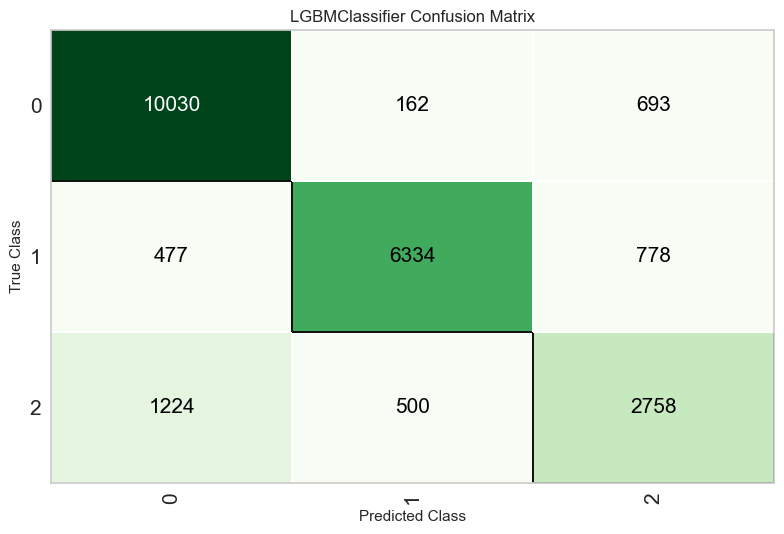

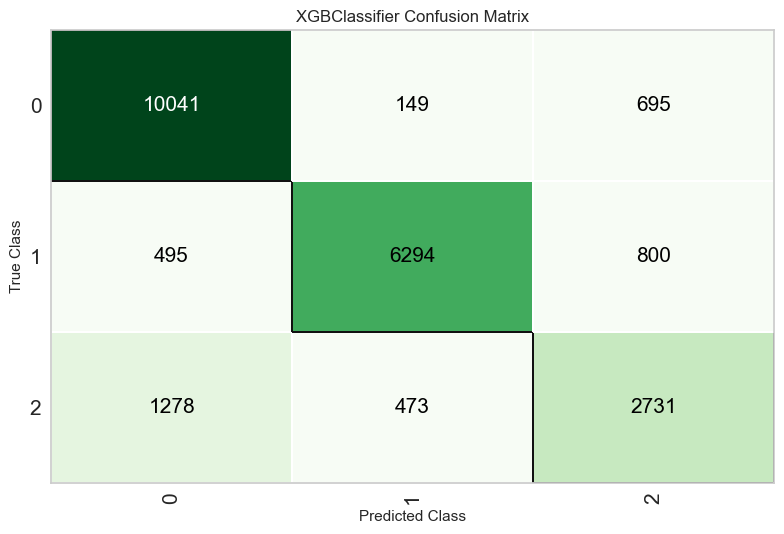

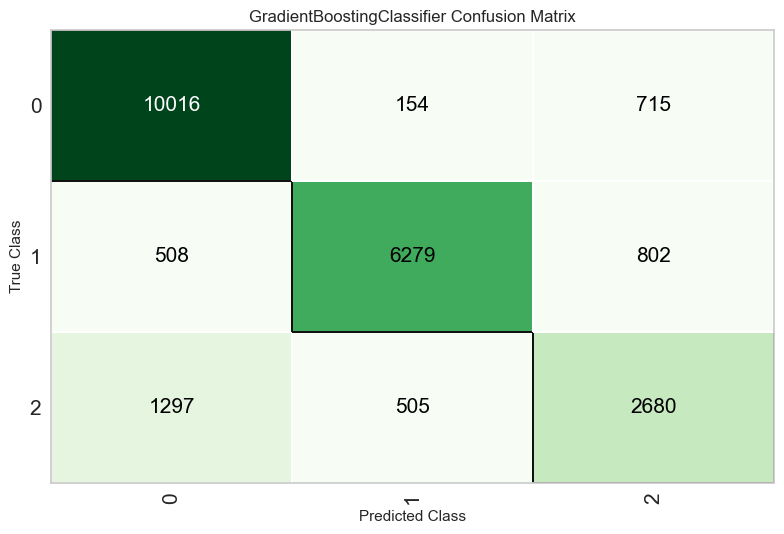

In [79]:
# Visualización del modelo
plot_model(tuned_dt1, plot='confusion_matrix')
plot_model(tuned_dt2, plot='confusion_matrix')
plot_model(dt3, plot='confusion_matrix')

In [80]:
# Visualización exhaustiva del modelo
evaluate_model(tuned_dt1)
evaluate_model(tuned_dt2)
evaluate_model(dt3)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [81]:
# Evaluar el modelo en el conjunto de prueba
predictions_test1 = predict_model(tuned_dt1)
predictions_test2 = predict_model(tuned_dt2)
predictions_test3 = predict_model(dt3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8330,0.9442,0.8330,0.8321,0.8313,0.7310,0.7324


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8305,0.9431,0.8305,0.8300,0.8289,0.7269,0.7285


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8266,0.9408,0.8266,0.8256,0.8247,0.7204,0.7220


In [82]:
predictions_train1 = predict_model(tuned_dt1, data=exp_clf101.get_config('X_train'))
predictions_train2 = predict_model(tuned_dt2, data=exp_clf101.get_config('X_train'))
predictions_train3 = predict_model(dt3, data=exp_clf101.get_config('X_train'))

In [83]:
y_train = get_config('y_train')
y_test = get_config('y_test')

In [84]:
from sklearn.metrics import accuracy_score, roc_auc_score
# Error de entrenamiento
print(accuracy_score(y_train,predictions_train1["prediction_label"]))
# Error de test
print(accuracy_score(y_test,predictions_test1["prediction_label"]))


0.8673499869310332
0.8329848405645582


In [85]:
from sklearn.metrics import accuracy_score, roc_auc_score
# Error de entrenamiento
print(accuracy_score(y_train,predictions_train2["prediction_label"]))
# Error de test
print(accuracy_score(y_test,predictions_test2["prediction_label"]))

0.8391583585377693
0.830545391183133


In [86]:
from sklearn.metrics import accuracy_score, roc_auc_score
# Error de entrenamiento
print(accuracy_score(y_train,predictions_train3["prediction_label"]))
# Error de test
print(accuracy_score(y_test,predictions_test3["prediction_label"]))

0.8325305253724655
0.8265812859383168


## Entrenamiento del modelo completo

In [109]:
%%time
# Finalizar el modelo
final_dt1 = finalize_model(tuned_dt1)
final_dt2 = finalize_model(tuned_dt2)
final_dt3 = finalize_model(dt3)

CPU times: total: 1min 57s
Wall time: 2min 54s


## Predicción nuevos datos

In [88]:
# Variables cuantitativas (Activar D1)
D1 = prueba.get(cuantitativas).copy()

# Variables categóricas
D2 = prueba.get(categoricas).copy()
for k in categoricas:
  D2[k] = D2[k].map(nombre_)
D4 = D2.copy()

# Variables al cuadrado (Activar D1)
cuadrado = [re.findall(r'(.+)_\d+', item) for item in c2]
cuadrado = [x[0] for x in cuadrado]

for k in cuadrado:
  D1[k+"_2"] = D1[k] ** 2

# Interacciones cuantitativas (Activar D1)
result = [re.findall(r'([A-Za-z\s\(\)0-9]+)', item) for item in cxy]

for k in result:
  D1[k[0]+"__"+k[1]] = D1[k[0]] * D1[k[1]]

# Razones
result2 = [re.findall(r'(.+)__coc__(.+)', item) for item in razxy]
for k in result2:
  k2 = k[0]
  D1[k2[0]+"__coc__"+k2[1]] = D1[k2[0]] / (D1[k2[1]]+0.01)

# Interacciones categóricas
result3 = [re.search(r'([^_]+__[^_]+)', item).group(1).split('__') for item in catxy]
for k in result3:
  D4[k[0]+"__"+k[1]] = D4[k[0]] + "_" + D4[k[1]]

# Interacción cuantitativa vs categórica
D5 = prueba.copy()
result4 = [re.search(r'(.+?)_(.+?)_1', item).groups() for item in cuactxy]
contador = 0
for k in result4:
  col1, col2 = k[1], k[0] # categórica, cuantitativa
  if contador == 0:
    D51 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D51.columns:
      D51[j] = D51[j] * D5[col2]
    D51.columns = [col2+""+col1+""+ str(x) for x in D51.columns]
  else:
    D52 = pd.get_dummies(D5[col1],drop_first=True)
    for j in D52.columns:
      D52[j] = D52[j] * D5[col2]
    D52.columns = [col2+""+col1+""+ str(x) for x in D52.columns]
    D51 = pd.concat([D51,D52],axis=1)
    contador = contador + 1

In [89]:
B1 = pd.concat([D1,D4],axis=1)
base_modelo2 = pd.concat([B1,D51],axis=1)
base_modelo2.head(3)

,Course,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),...,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,International,Tuition fees up to date__Scholarship holder,Educational special needs__Tuition fees up to date,Gender__Scholarship holder,Curricular units 2nd sem (enrolled)Tuition fees up to date1
0,9500,1,141.0,3,1,152.1,18,0,7,0,...,C0,C0,C0,C0,C0,C0,C0_C0,C0_C0,C0_C0,0
1,9238,1,128.0,1,19,116.5,19,0,6,7,...,C0,C0,C1,C0,C0,C0,C1_C0,C0_C1,C0_C0,6
2,9238,1,118.0,1,19,114.2,18,0,6,11,...,C0,C0,C1,C0,C1,C0,C1_C1,C0_C1,C0_C1,6


In [90]:
df_test1 = base_modelo2.copy()
column_types = df_test1.dtypes
df_test2 = base_modelo2.copy()
column_types = df_test2.dtypes
df_test3 = base_modelo2.copy()
column_types = df_test3.dtypes


In [91]:
# Realizar predicciones
predictions1 = predict_model(final_dt1, data=df_test1)

In [92]:
predictions2 = predict_model(final_dt2, data=df_test2)

In [93]:
predictions3 = predict_model(final_dt3, data=df_test3)

In [94]:
predictions1["prediction_label"].value_counts()

prediction_label
0    26399
1    15315
2     9298
Name: count, dtype: int64

In [95]:
predictions2["prediction_label"].value_counts()

prediction_label
0    26495
1    15219
2     9298
Name: count, dtype: int64

In [96]:
predictions3["prediction_label"].value_counts()

prediction_label
0    26477
1    15197
2     9338
Name: count, dtype: int64

In [97]:
print(df_test2.columns)


Index(['Course', 'Previous qualification', 'Previous qualification (grade)',
       'Mother's qualification', 'Father's qualification', 'Admission grade',
       'Age at enrollment', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Curricular units 2nd sem (approved)_2',
       'Curricular units 2nd sem (enrolled)_2',
       'Curricular units 2nd sem (evaluations)_2',
       'Admission grade__Curricular units 2nd sem (approv

## Archivo kaggle

In [98]:
prueba.head(2)

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,76518,1,1,1,9500,1,1,141.0,1,3,...,0,0,8,0,0,0.0,0,13.9,-0.3,0.79
1,76519,1,1,1,9238,1,1,128.0,1,1,...,0,0,6,6,6,13.5,0,11.1,0.6,2.02


In [99]:
prueba2 = prueba
prueba2['id'] = prueba['id'].astype('O')

In [100]:
# Create a DataFrame with 'id' and 'Exited' probabilities
result1 = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions1["prediction_label"]
})

result1["Target"] = result1["Target"].map(int)
result1.tail(5)

,id,Target
51007,127525,1
51008,127526,1
51009,127527,1
51010,127528,1
51011,127529,1


In [101]:
# Create a DataFrame with 'id' and 'Exited' probabilities
result2 = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions2["prediction_label"]
})

result2["Target"] = result2["Target"].map(int)
result2.head(5)

,id,Target
0,76518,1
1,76519,0
2,76520,0
3,76521,2
4,76522,2


In [102]:
# Create a DataFrame with 'id' and 'Exited' probabilities
result3 = pd.DataFrame({
    'id': prueba["id"],
    'Target': predictions3["prediction_label"]
})

result3["Target"] = result3["Target"].map(int)
result3.head(5)

,id,Target
0,76518,1
1,76519,0
2,76520,0
3,76521,2
4,76522,2


In [103]:
inverse_category_mapping = {
    0: 'Graduate',
    1: 'Dropout',
    2: 'Enrolled'
}

# Aplicar el mapeo inverso a la columna 'Target'
result1['Target'] = result1['Target'].map(inverse_category_mapping)

# Verificar los resultados
print(result1['Target'])

0         Dropout
1        Graduate
2        Graduate
3        Enrolled
4        Enrolled
           ...   
51007     Dropout
51008     Dropout
51009     Dropout
51010     Dropout
51011     Dropout
Name: Target, Length: 51012, dtype: object


In [104]:
inverse_category_mapping = {
    0: 'Graduate',
    1: 'Dropout',
    2: 'Enrolled'
}

# Aplicar el mapeo inverso a la columna 'Target'
result2['Target'] = result2['Target'].map(inverse_category_mapping)

# Verificar los resultados
print(result2['Target'])

0         Dropout
1        Graduate
2        Graduate
3        Enrolled
4        Enrolled
           ...   
51007     Dropout
51008     Dropout
51009     Dropout
51010     Dropout
51011     Dropout
Name: Target, Length: 51012, dtype: object


In [105]:
inverse_category_mapping = {
    0: 'Graduate',
    1: 'Dropout',
    2: 'Enrolled'
}

# Aplicar el mapeo inverso a la columna 'Target'
result3['Target'] = result3['Target'].map(inverse_category_mapping)

# Verificar los resultados
print(result3['Target'])

0         Dropout
1        Graduate
2        Graduate
3        Enrolled
4        Enrolled
           ...   
51007     Dropout
51008     Dropout
51009     Dropout
51010     Dropout
51011     Dropout
Name: Target, Length: 51012, dtype: object


In [106]:
# Save the result to a CSV file
result1.to_csv(path + 'subbmision_mod1_CIV3.csv', index=False,sep=",")
# Guardar y cargar modelos
save_model(final_dt1, path + 'final_dt1_model_customer_churn')

# To load the model later
loaded_model = load_model(path + 'final_dt1_model_customer_churn')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


In [107]:
# Save the result to a CSV file
result2.to_csv(path + 'subbmision_mod2_CIV1.csv', index=False,sep=",")
# Guardar y cargar modelos
save_model(final_dt2, path + 'final_dt2_model_customer_churn')

# To load the model later
loaded_model = load_model(path + 'final_dt2_model_customer_churn')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


In [108]:
# Save the result to a CSV file
result3.to_csv(path + 'subbmision_mod3_CIV2.csv', index=False,sep=",")
# Guardar y cargar modelos
save_model(final_dt3, path + 'final_dt3_model_customer_churn')

# To load the model later
loaded_model = load_model(path + 'final_dt3_model_customer_churn')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


## 2. Código para construcción de API

In [114]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  object 
 2   Application mode                                76518 non-null  object 
 3   Application order                               76518 non-null  object 
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  object 
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  object 
 9   Mother's qualification                 

In [110]:
df.iloc[0,]

id                                                        0
Marital status                                            1
Application mode                                          1
Application order                                         1
Course                                                 9238
Daytime/evening attendance                                1
Previous qualification                                    1
Previous qualification (grade)                        126.0
Nacionality                                               1
Mother's qualification                                    1
Father's qualification                                   19
Mother's occupation                                       5
Father's occupation                                       5
Admission grade                                       122.6
Displaced                                                 0
Educational special needs                                 0
Debtor                                  